### Time Series Forecasting using Feed Forward Neural Network

This example shows the usage of Simple Feed Forward Neural Network using TensorFlow. Neural Networks became a hype during the last years especially in image recognitions, but it can also be used forecasting purposes on time series There are also a lot different types of Neural Networks you can use to solve time series forecasting, but this notebook focus is on using simple full connected Feed Forward Neural Networks.  


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow import keras
import tensorflow as tf
from IPython.display import display

In [2]:
df=pd.read_csv("../data/AirPassengers.csv")
df.columns=["Period","Passengers"]
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
Period        144 non-null object
Passengers    144 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ KB
None


,Period,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


## Data Preparation

For this time series forecasting, I will use only the time series of the passengers column. I will also use only the periods till 1959/12 for the training process to hold the year 1960 of real data for comparison reasons. Therefore we want to forecast the whole year 1960. 


#### 1.Step Preprocessing Data


First we need to scale the data. 



In [3]:
dfTraining=df.iloc[:-12].copy()
df1960=df[-12:].copy()
df1960

,Period,Passengers
132,1960-01,417
133,1960-02,391
134,1960-03,419
135,1960-04,461
136,1960-05,472
137,1960-06,535
138,1960-07,622
139,1960-08,606
140,1960-09,508
141,1960-10,461


The next step is to scale the data. Scaling is not always necessary. It depends first on the activation function of the Neural Network Model you want to use and second if you have different types of input features you can level the importances with scaling. In our case I use a MinMaxScaler with a range of 0.1-0.9    

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0.1, 0.9))
series_scaled = scaler.fit_transform(dfTraining["Passengers"].values.reshape(-1,1))
dfTraining["PassengersScaled"]=series_scaled
display(dfTraining.head(6))
display(dfTraining.tail(14))

,Period,Passengers,PassengersScaled
0,1949-01,112,0.114066
1,1949-02,118,0.124615
2,1949-03,132,0.149231
3,1949-04,129,0.143956
4,1949-05,121,0.129890
5,1949-06,135,0.154505


,Period,Passengers,PassengersScaled
118,1958-11,310,0.462198
119,1958-12,337,0.509670
120,1959-01,360,0.550110
121,1959-02,342,0.518462
122,1959-03,406,0.630989
123,1959-04,396,0.613407
124,1959-05,420,0.655604
125,1959-06,472,0.747033
126,1959-07,548,0.880659
127,1959-08,559,0.900000


The idea behind using Neural Networks  for this usage to make rolling slices of time frames, where a past period describes a future period. In our case we want to predict 12 month and it is a good choice to use also a timeframe of 12 month of the past.
Over the whole training data series, the function build an input array with 12 inputs and a target array with 12 targets

In [5]:
ts_input_size=12
ts_target_size=12
training_flat=dfTraining["PassengersScaled"].values.reshape(-1,1).astype("float32")
trainX=[]
trainY=[]
for i in range(len(training_flat)-ts_target_size-ts_input_size+1):
    x=training_flat[i:(i+ts_input_size),0]
    y=training_flat[(i+ts_input_size):(i+ts_input_size+ts_target_size),0]
    trainX.append(x)
    trainY.append(y)

trainX=np.array(trainX)
trainY=np.array(trainY)
print("Training Set Length :{}\r\nInput Values({}):\r\n{}\r\n\r\nTarget Values({}):\r\n{}".format(
    len(training_flat),len(trainX),trainX,len(trainY),trainY))


Training Set Length :132
Input Values(109):
[[0.11406594 0.12461539 0.14923076 ... 0.12637363 0.1        0.12461539]
 [0.12461539 0.14923076 0.14395605 ... 0.1        0.12461539 0.11934066]
 [0.14923076 0.14395605 0.12989011 ... 0.12461539 0.11934066 0.13868132]
 ...
 [0.4534066  0.5079121  0.51494503 ... 0.80505496 0.6274725  0.54835165]
 [0.5079121  0.51494503 0.47626373 ... 0.6274725  0.54835165 0.4621978 ]
 [0.51494503 0.47626373 0.55362636 ... 0.54835165 0.4621978  0.5096703 ]]

Target Values(109):
[[0.11934066 0.13868132 0.16505495 ... 0.15098901 0.11758242 0.1632967 ]
 [0.13868132 0.16505495 0.15450549 ... 0.11758242 0.1632967  0.17208791]
 [0.16505495 0.15450549 0.13692307 ... 0.1632967  0.17208791 0.18087912]
 ...
 [0.4621978  0.5096703  0.55010986 ... 0.9        0.7312088  0.63274723]
 [0.5096703  0.55010986 0.5184615  ... 0.7312088  0.63274723 0.55362636]
 [0.55010986 0.5184615  0.630989   ... 0.63274723 0.55362636 0.6292308 ]]


##### Disadvantages:
if you take a large time series on the target you lose the content of this period during the training process. If you don't have large time series for the training you need to use smaller time frames. In another notebook I will show how this can be handled too. 

#### Preparing the data for the prediction input
We will use a neural network with 12 input neurons and 12 target neurons. If we want to forecast the year 1960 then we need for the input an array with the 12 values of 1959

In [6]:
predictX=[training_flat[-ts_input_size:,0]]
predictX=np.array(predictX)
predictX

array([[0.55010986, 0.5184615 , 0.630989  , 0.6134066 , 0.6556044 ,
        0.74703294, 0.88065934, 0.9       , 0.7312088 , 0.63274723,
        0.55362636, 0.6292308 ]], dtype=float32)

#### Training Data - Test Data Split
Again, for the training process of a neural network it is also import to have a test set of data, which is used to calculate the quality of the model (cross validation). I take 10% of the training data for the cross validation

In [7]:
from sklearn.model_selection import train_test_split
x_trainbatches, x_testbatches, y_trainbatches, y_testbatches = train_test_split(
            trainX, trainY, test_size=0.1, random_state=42)
print(x_testbatches)
print("Training observations: {}  -  Testing observations: {}".format(len(x_trainbatches),len(x_testbatches)))

[[0.55714285 0.52725273 0.46571428 0.3989011  0.33384615 0.40593407
  0.41648352 0.40417582 0.47450548 0.46747252 0.47626373 0.5747253 ]
 [0.1        0.12461539 0.11934066 0.13868132 0.16505495 0.15450549
  0.13692307 0.17912088 0.21604395 0.21604395 0.19494505 0.15098901]
 [0.12989011 0.15450549 0.17736264 0.17736264 0.15626374 0.12637363
  0.1        0.12461539 0.11934066 0.13868132 0.16505495 0.15450549]
 [0.41648352 0.40417582 0.47450548 0.46747252 0.47626373 0.5747253
  0.6432967  0.6292308  0.54131866 0.45516485 0.39362636 0.45516485]
 [0.32857144 0.3813187  0.44813186 0.4323077  0.37252748 0.31978023
  0.27406594 0.31978023 0.34263736 0.3268132  0.3865934  0.3901099 ]
 [0.37252748 0.31978023 0.27406594 0.31978023 0.34263736 0.3268132
  0.3865934  0.3901099  0.39186814 0.47098902 0.55714285 0.52725273]
 [0.26703298 0.26703298 0.24065934 0.20197803 0.17384616 0.20901099
  0.2178022  0.23362638 0.25648353 0.23538461 0.2389011  0.30043957]
 [0.25296703 0.21956044 0.25824177 0.261758

#### Neural Network

Next, we will create a Neural Network Model and train the model with our training data.

<b>Tip:</b> To get reproduceable results, I always set the random generators initial values to fixed values. If you don't do that, each run of the training process will reproduce other results as the weights of the layers will initialized with different random values. If the quality of a Neural Network is bad you can also try several different initial seeds to see, if the quality depands on intial values.

In [8]:
seed=8172
np.random.seed(seed)
tf.random.set_seed(seed)

The model has 12 input neuron and 12 target neurons on the output side. For the first try I use a model with two hidden layers and as the activation function I used ReLU (Rectifier Linear Unit). For regression models like the current, my experiences with ReLU are very good. Sigmoid and TanH tends to flatten values near the edges of the scaling. In our case as the value tends to grow over the years, the prediction results will be foturnatly near the upper edge. 

#### Hidden Layer Sizes

This is one of the million-dollar questions. There is no calculation you can use to define the optimal sizes and there is also no calculation available to define how many layers to use. It depends on the size of the input  and output layer as well as on the size of the training input data and also on degrees of freedom between the input and output data. Also import for this size it is if you want to get a more generalized model or a more detailed model. 

<b>Ho do I solve this in practice:</b> Well, first I normally try several configuration with a wide range of layers and sizes. Comparing the cross validations give in most cases a better feeling about the ranges of good models. Then I try smaller ranges of model with a good quality. 

In [9]:
model=keras.Sequential()
model.add(keras.layers.Dense(37,activation='relu', input_dim=ts_input_size, use_bias=True))
model.add(keras.layers.Dense(19,activation='relu', use_bias=True))
model.add(keras.layers.Dense(ts_target_size, activation='relu', use_bias=True))

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_squared_error']
)
history=model.fit(x_trainbatches, y_trainbatches, epochs=5000,
                               batch_size=len(x_trainbatches),
                               validation_data=(x_testbatches, y_testbatches),
                               validation_freq=100, 
                               use_multiprocessing=True)

Epoch 1/5000
1/1 [==============================] - 0s 0s/step - loss: 0.1355 - mean_squared_error: 0.1355
Epoch 2/5000
1/1 [==============================] - 0s 0s/step - loss: 0.1303 - mean_squared_error: 0.1303
Epoch 3/5000
1/1 [==============================] - 0s 0s/step - loss: 0.1253 - mean_squared_error: 0.1253
Epoch 4/5000
1/1 [==============================] - 0s 0s/step - loss: 0.1203 - mean_squared_error: 0.1203
Epoch 5/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.1156 - mean_squared_error: 0.1156
Epoch 6/5000
1/1 [==============================] - 0s 998us/step - loss: 0.1111 - mean_squared_error: 0.1111
Epoch 7/5000
1/1 [==============================] - 0s 0s/step - loss: 0.1069 - mean_squared_error: 0.1069
Epoch 8/5000
1/1 [==============================] - 0s 0s/step - loss: 0.1030 - mean_squared_error: 0.1030
Epoch 9/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0993 - mean_squared_error: 0.0993
Epoch 10/5000
1/1 [==============

1/1 [==============================] - 0s 0s/step - loss: 0.0524 - mean_squared_error: 0.0524
Epoch 77/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0524 - mean_squared_error: 0.0524
Epoch 78/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0524 - mean_squared_error: 0.0524
Epoch 79/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0523 - mean_squared_error: 0.0523
Epoch 80/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0523 - mean_squared_error: 0.0523
Epoch 81/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0523 - mean_squared_error: 0.0523
Epoch 82/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0523 - mean_squared_error: 0.0523
Epoch 83/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0523 - mean_squared_error: 0.0523
Epoch 84/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0522 - mean_squared_error: 0.0522
Epoch 85/5000
1/1 [===================

1/1 [==============================] - 0s 0s/step - loss: 0.0514 - mean_squared_error: 0.0514
Epoch 151/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0514 - mean_squared_error: 0.0514
Epoch 152/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0514 - mean_squared_error: 0.0514
Epoch 153/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0513 - mean_squared_error: 0.0513
Epoch 154/5000
1/1 [==============================] - 0s 10ms/step - loss: 0.0513 - mean_squared_error: 0.0513
Epoch 155/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0513 - mean_squared_error: 0.0513
Epoch 156/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0513 - mean_squared_error: 0.0513
Epoch 157/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0513 - mean_squared_error: 0.0513
Epoch 158/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0513 - mean_squared_error: 0.0513
Epoch 159/5000
1/1 [============

1/1 [==============================] - 0s 1ms/step - loss: 0.0506 - mean_squared_error: 0.0506
Epoch 225/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.0506 - mean_squared_error: 0.0506
Epoch 226/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0506 - mean_squared_error: 0.0506
Epoch 227/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0506 - mean_squared_error: 0.0506
Epoch 228/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0506 - mean_squared_error: 0.0506
Epoch 229/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0506 - mean_squared_error: 0.0506
Epoch 230/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0506 - mean_squared_error: 0.0506
Epoch 231/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0506 - mean_squared_error: 0.0506
Epoch 232/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0506 - mean_squared_error: 0.0506
Epoch 233/5000
1/1 [============

1/1 [==============================] - 0s 0s/step - loss: 0.0501 - mean_squared_error: 0.0501
Epoch 299/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0500 - mean_squared_error: 0.0500
Epoch 300/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0500 - mean_squared_error: 0.0500 - val_loss: 0.0479 - val_mean_squared_error: 0.0479
Epoch 301/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0500 - mean_squared_error: 0.0500
Epoch 302/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0500 - mean_squared_error: 0.0500
Epoch 303/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0500 - mean_squared_error: 0.0500
Epoch 304/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0500 - mean_squared_error: 0.0500
Epoch 305/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0500 - mean_squared_error: 0.0500
Epoch 306/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0500 - mean_squa

1/1 [==============================] - 0s 0s/step - loss: 0.0498 - mean_squared_error: 0.0498
Epoch 373/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0498 - mean_squared_error: 0.0498
Epoch 374/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0497 - mean_squared_error: 0.0497
Epoch 375/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0497 - mean_squared_error: 0.0497
Epoch 376/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0497 - mean_squared_error: 0.0497
Epoch 377/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0497 - mean_squared_error: 0.0497
Epoch 378/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0497 - mean_squared_error: 0.0497
Epoch 379/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0497 - mean_squared_error: 0.0497
Epoch 380/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0497 - mean_squared_error: 0.0497
Epoch 381/5000
1/1 [==============

1/1 [==============================] - 0s 0s/step - loss: 0.0496 - mean_squared_error: 0.0496
Epoch 447/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0496 - mean_squared_error: 0.0496
Epoch 448/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0496 - mean_squared_error: 0.0496
Epoch 449/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0496 - mean_squared_error: 0.0496
Epoch 450/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0496 - mean_squared_error: 0.0496
Epoch 451/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0496 - mean_squared_error: 0.0496
Epoch 452/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0496 - mean_squared_error: 0.0496
Epoch 453/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0496 - mean_squared_error: 0.0496
Epoch 454/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0496 - mean_squared_error: 0.0496
Epoch 455/5000
1/1 [==============

1/1 [==============================] - 0s 0s/step - loss: 0.0495 - mean_squared_error: 0.0495
Epoch 521/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0495 - mean_squared_error: 0.0495
Epoch 522/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.0495 - mean_squared_error: 0.0495
Epoch 523/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.0495 - mean_squared_error: 0.0495
Epoch 524/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.0495 - mean_squared_error: 0.0495
Epoch 525/5000
1/1 [==============================] - 0s 998us/step - loss: 0.0495 - mean_squared_error: 0.0495
Epoch 526/5000
1/1 [==============================] - 0s 995us/step - loss: 0.0495 - mean_squared_error: 0.0495
Epoch 527/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0495 - mean_squared_error: 0.0495
Epoch 528/5000
1/1 [==============================] - 0s 999us/step - loss: 0.0495 - mean_squared_error: 0.0495
Epoch 529/5000
1/1 [

1/1 [==============================] - 0s 0s/step - loss: 0.0494 - mean_squared_error: 0.0494
Epoch 595/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0494 - mean_squared_error: 0.0494
Epoch 596/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0494 - mean_squared_error: 0.0494
Epoch 597/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0494 - mean_squared_error: 0.0494
Epoch 598/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0494 - mean_squared_error: 0.0494
Epoch 599/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0494 - mean_squared_error: 0.0494
Epoch 600/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0494 - mean_squared_error: 0.0494 - val_loss: 0.0474 - val_mean_squared_error: 0.0474
Epoch 601/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0494 - mean_squared_error: 0.0494
Epoch 602/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0494 - mean_sq

1/1 [==============================] - 0s 999us/step - loss: 0.0494 - mean_squared_error: 0.0494
Epoch 668/5000
1/1 [==============================] - 0s 997us/step - loss: 0.0494 - mean_squared_error: 0.0494
Epoch 669/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.0494 - mean_squared_error: 0.0494
Epoch 670/5000
1/1 [==============================] - 0s 330us/step - loss: 0.0494 - mean_squared_error: 0.0494
Epoch 671/5000
1/1 [==============================] - 0s 998us/step - loss: 0.0494 - mean_squared_error: 0.0494
Epoch 672/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.0494 - mean_squared_error: 0.0494
Epoch 673/5000
1/1 [==============================] - 0s 999us/step - loss: 0.0493 - mean_squared_error: 0.0493
Epoch 674/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.0493 - mean_squared_error: 0.0493
Epoch 675/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.0493 - mean_squared_error: 0.0493
Epoch 676/5000


1/1 [==============================] - 0s 998us/step - loss: 0.0493 - mean_squared_error: 0.0493
Epoch 742/5000
1/1 [==============================] - 0s 999us/step - loss: 0.0493 - mean_squared_error: 0.0493
Epoch 743/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0493 - mean_squared_error: 0.0493
Epoch 744/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0493 - mean_squared_error: 0.0493
Epoch 745/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0493 - mean_squared_error: 0.0493
Epoch 746/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0493 - mean_squared_error: 0.0493
Epoch 747/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0493 - mean_squared_error: 0.0493
Epoch 748/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0493 - mean_squared_error: 0.0493
Epoch 749/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0493 - mean_squared_error: 0.0493
Epoch 750/5000
1/1 [========

1/1 [==============================] - 0s 0s/step - loss: 0.0492 - mean_squared_error: 0.0492
Epoch 816/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0492 - mean_squared_error: 0.0492
Epoch 817/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0492 - mean_squared_error: 0.0492
Epoch 818/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0492 - mean_squared_error: 0.0492
Epoch 819/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0492 - mean_squared_error: 0.0492
Epoch 820/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0492 - mean_squared_error: 0.0492
Epoch 821/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0492 - mean_squared_error: 0.0492
Epoch 822/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0492 - mean_squared_error: 0.0492
Epoch 823/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0492 - mean_squared_error: 0.0492
Epoch 824/5000
1/1 [==============

1/1 [==============================] - 0s 0s/step - loss: 0.0492 - mean_squared_error: 0.0492
Epoch 890/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0492 - mean_squared_error: 0.0492
Epoch 891/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0492 - mean_squared_error: 0.0492
Epoch 892/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0492 - mean_squared_error: 0.0492
Epoch 893/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0492 - mean_squared_error: 0.0492
Epoch 894/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0492 - mean_squared_error: 0.0492
Epoch 895/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0492 - mean_squared_error: 0.0492
Epoch 896/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0492 - mean_squared_error: 0.0492
Epoch 897/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0492 - mean_squared_error: 0.0492
Epoch 898/5000
1/1 [==============

1/1 [==============================] - 0s 0s/step - loss: 0.0491 - mean_squared_error: 0.0491
Epoch 964/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0491 - mean_squared_error: 0.0491
Epoch 965/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0491 - mean_squared_error: 0.0491
Epoch 966/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0491 - mean_squared_error: 0.0491
Epoch 967/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0491 - mean_squared_error: 0.0491
Epoch 968/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0491 - mean_squared_error: 0.0491
Epoch 969/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0491 - mean_squared_error: 0.0491
Epoch 970/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0491 - mean_squared_error: 0.0491
Epoch 971/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0491 - mean_squared_error: 0.0491
Epoch 972/5000
1/1 [============

1/1 [==============================] - 0s 0s/step - loss: 0.0491 - mean_squared_error: 0.0491
Epoch 1038/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0491 - mean_squared_error: 0.0491
Epoch 1039/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0491 - mean_squared_error: 0.0491
Epoch 1040/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0491 - mean_squared_error: 0.0491
Epoch 1041/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0491 - mean_squared_error: 0.0491
Epoch 1042/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0491 - mean_squared_error: 0.0491
Epoch 1043/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0491 - mean_squared_error: 0.0491
Epoch 1044/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0491 - mean_squared_error: 0.0491
Epoch 1045/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0491 - mean_squared_error: 0.0491
Epoch 1046/5000
1/1 [===

1/1 [==============================] - 0s 0s/step - loss: 0.0491 - mean_squared_error: 0.0491
Epoch 1111/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0491 - mean_squared_error: 0.0491
Epoch 1112/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0491 - mean_squared_error: 0.0491
Epoch 1113/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0491 - mean_squared_error: 0.0491
Epoch 1114/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0491 - mean_squared_error: 0.0491
Epoch 1115/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0491 - mean_squared_error: 0.0491
Epoch 1116/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0491 - mean_squared_error: 0.0491
Epoch 1117/5000
1/1 [==============================] - 0s 13ms/step - loss: 0.0491 - mean_squared_error: 0.0491
Epoch 1118/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0491 - mean_squared_error: 0.0491
Epoch 1119/5000
1/1 [===

1/1 [==============================] - 0s 0s/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 1185/5000
1/1 [==============================] - 0s 999us/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 1186/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 1187/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 1188/5000
1/1 [==============================] - 0s 998us/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 1189/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 1190/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 1191/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 1192/5000
1/1 [==============================] - 0s 998us/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 1193/500

1/1 [==============================] - 0s 1000us/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 1258/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 1259/5000
1/1 [==============================] - 0s 1000us/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 1260/5000
1/1 [==============================] - 0s 999us/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 1261/5000
1/1 [==============================] - 0s 999us/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 1262/5000
1/1 [==============================] - 0s 999us/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 1263/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 1264/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 1265/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 1

1/1 [==============================] - 0s 7ms/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 1331/5000
1/1 [==============================] - 0s 998us/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 1332/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 1333/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 1334/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 1335/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 1336/5000
1/1 [==============================] - 0s 998us/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 1337/5000
1/1 [==============================] - 0s 1000us/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 1338/5000
1/1 [==============================] - 0s 998us/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 13

1/1 [==============================] - 0s 16ms/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 1404/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 1405/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 1406/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 1407/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 1408/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 1409/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 1410/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 1411/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 1412/5000
1/1 [===

1/1 [==============================] - 0s 1ms/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 1478/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 1479/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 1480/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 1481/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 1482/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 1483/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 1484/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 1485/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 1486/5000
1/1 [====

1/1 [==============================] - 0s 0s/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 1551/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 1552/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 1553/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 1554/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 1555/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 1556/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 1557/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 1558/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 1559/5000
1/1 [=====

1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 1625/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 1626/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 1627/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 1628/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 1629/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 1630/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 1631/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 1632/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 1633/5000
1/1 [====

1/1 [==============================] - 0s 1ms/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 1699/5000
1/1 [==============================] - 0s 997us/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 1700/5000
1/1 [==============================] - 0s 12ms/step - loss: 0.0489 - mean_squared_error: 0.0489 - val_loss: 0.0469 - val_mean_squared_error: 0.0469
Epoch 1701/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 1702/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 1703/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 1704/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 1705/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 1706/5000
1/1 [==============================] - 0s 0s/step - loss: 0.04

1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 1772/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 1773/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 1774/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 1775/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 1776/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 1777/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 1778/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 1779/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 1780/5000
1/1 [=====

1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 1846/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 1847/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 1848/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 1849/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 1850/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 1851/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 1852/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 1853/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 1854/5000
1/1 [===

1/1 [==============================] - 0s 999us/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 1919/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 1920/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 1921/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 1922/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 1923/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 1924/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 1925/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 1926/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 1927/5000
1/1 

1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 1993/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 1994/5000
1/1 [==============================] - 0s 7ms/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 1995/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 1996/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 1997/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 1998/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 1999/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 2000/5000
1/1 [==============================] - 0s 28ms/step - loss: 0.0489 - mean_squared_error: 0.0489 - val_loss: 0.0469 - va

1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 2066/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 2067/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 2068/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 2069/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 2070/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 2071/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 2072/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 2073/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 2074/5000
1/1 [=====

1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 2140/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 2141/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 2142/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 2143/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 2144/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 2145/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 2146/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 2147/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 2148/5000
1/1 [===

1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 2213/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 2214/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 2215/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 2216/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 2217/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 2218/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 2219/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 2220/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 2221/5000
1/1 [===

1/1 [==============================] - 0s 16ms/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 2287/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 2288/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 2289/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 2290/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 2291/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 2292/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 2293/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 2294/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 2295/5000
1/1 [=

Epoch 2360/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.0488 - mean_squared_error: 0.0488
Epoch 2361/5000
1/1 [==============================] - 0s 998us/step - loss: 0.0488 - mean_squared_error: 0.0488
Epoch 2362/5000
1/1 [==============================] - 0s 996us/step - loss: 0.0488 - mean_squared_error: 0.0488
Epoch 2363/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.0488 - mean_squared_error: 0.0488
Epoch 2364/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0488 - mean_squared_error: 0.0488
Epoch 2365/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0488 - mean_squared_error: 0.0488
Epoch 2366/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0488 - mean_squared_error: 0.0488
Epoch 2367/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0488 - mean_squared_error: 0.0488
Epoch 2368/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0488 - mean_squared_error: 0.0488
E

1/1 [==============================] - 0s 0s/step - loss: 0.0350 - mean_squared_error: 0.0350
Epoch 2434/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0342 - mean_squared_error: 0.0342
Epoch 2435/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0339 - mean_squared_error: 0.0339
Epoch 2436/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0341 - mean_squared_error: 0.0341
Epoch 2437/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0346 - mean_squared_error: 0.0346
Epoch 2438/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0350 - mean_squared_error: 0.0350
Epoch 2439/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0351 - mean_squared_error: 0.0351
Epoch 2440/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0349 - mean_squared_error: 0.0349
Epoch 2441/5000
1/1 [==============================] - 0s 999us/step - loss: 0.0346 - mean_squared_error: 0.0346
Epoch 2442/5000
1/1 [

1/1 [==============================] - 0s 1ms/step - loss: 0.0322 - mean_squared_error: 0.0322
Epoch 2507/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.0322 - mean_squared_error: 0.0322
Epoch 2508/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.0322 - mean_squared_error: 0.0322
Epoch 2509/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.0322 - mean_squared_error: 0.0322
Epoch 2510/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.0322 - mean_squared_error: 0.0322
Epoch 2511/5000
1/1 [==============================] - 0s 997us/step - loss: 0.0322 - mean_squared_error: 0.0322
Epoch 2512/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.0321 - mean_squared_error: 0.0321
Epoch 2513/5000
1/1 [==============================] - 0s 1000us/step - loss: 0.0321 - mean_squared_error: 0.0321
Epoch 2514/5000
1/1 [==============================] - 0s 996us/step - loss: 0.0321 - mean_squared_error: 0.0321
Epoch 2515

1/1 [==============================] - 0s 0s/step - loss: 0.0320 - mean_squared_error: 0.0320
Epoch 2581/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0320 - mean_squared_error: 0.0320
Epoch 2582/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0320 - mean_squared_error: 0.0320
Epoch 2583/5000
1/1 [==============================] - 0s 7ms/step - loss: 0.0320 - mean_squared_error: 0.0320
Epoch 2584/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0320 - mean_squared_error: 0.0320
Epoch 2585/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0320 - mean_squared_error: 0.0320
Epoch 2586/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0320 - mean_squared_error: 0.0320
Epoch 2587/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0320 - mean_squared_error: 0.0320
Epoch 2588/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0320 - mean_squared_error: 0.0320
Epoch 2589/5000
1/1 [====

1/1 [==============================] - 0s 0s/step - loss: 0.0319 - mean_squared_error: 0.0319
Epoch 2655/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0319 - mean_squared_error: 0.0319
Epoch 2656/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0319 - mean_squared_error: 0.0319
Epoch 2657/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0319 - mean_squared_error: 0.0319
Epoch 2658/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0319 - mean_squared_error: 0.0319
Epoch 2659/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0319 - mean_squared_error: 0.0319
Epoch 2660/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0319 - mean_squared_error: 0.0319
Epoch 2661/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.0319 - mean_squared_error: 0.0319
Epoch 2662/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0319 - mean_squared_error: 0.0319
Epoch 2663/5000
1/1 [==

1/1 [==============================] - 0s 0s/step - loss: 0.0319 - mean_squared_error: 0.0319
Epoch 2728/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0319 - mean_squared_error: 0.0319
Epoch 2729/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0319 - mean_squared_error: 0.0319
Epoch 2730/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0319 - mean_squared_error: 0.0319
Epoch 2731/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0319 - mean_squared_error: 0.0319
Epoch 2732/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0319 - mean_squared_error: 0.0319
Epoch 2733/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0319 - mean_squared_error: 0.0319
Epoch 2734/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0319 - mean_squared_error: 0.0319
Epoch 2735/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0319 - mean_squared_error: 0.0319
Epoch 2736/5000
1/1 [=====

1/1 [==============================] - 0s 0s/step - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 2802/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 2803/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 2804/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 2805/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 2806/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 2807/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 2808/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 2809/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 2810/5000
1/1 [=====

1/1 [==============================] - 0s 16ms/step - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 2876/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 2877/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 2878/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 2879/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 2880/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 2881/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 2882/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 2883/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 2884/5000
1/1 [==

1/1 [==============================] - 0s 997us/step - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 2949/5000
1/1 [==============================] - 0s 997us/step - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 2950/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 2951/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 2952/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 2953/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 2954/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 2955/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 2956/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 2957/5000
1/1

Epoch 3022/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 3023/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 3024/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 3025/5000
1/1 [==============================] - 0s 997us/step - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 3026/5000
1/1 [==============================] - 0s 999us/step - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 3027/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 3028/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 3029/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 3030/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0318 - mean_squared_error: 0.0318
Epo

1/1 [==============================] - 0s 1ms/step - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 3097/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 3098/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 3099/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 3100/5000
1/1 [==============================] - 0s 21ms/step - loss: 0.0318 - mean_squared_error: 0.0318 - val_loss: 0.0309 - val_mean_squared_error: 0.0309
Epoch 3101/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 3102/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 3103/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 3104/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0318 

1/1 [==============================] - 0s 1000us/step - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 3170/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 3171/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 3172/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 3173/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 3174/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 3175/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 3176/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 3177/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 3178/5000
1

1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3243/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3244/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3245/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3246/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3247/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3248/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3249/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3250/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3251/5000
1/1 [=====

1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3317/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3318/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3319/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3320/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3321/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3322/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3323/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3324/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3325/5000
1/1 [=====

1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3391/5000
1/1 [==============================] - 0s 999us/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3392/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3393/5000
1/1 [==============================] - 0s 999us/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3394/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3395/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3396/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3397/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3398/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3399/5000
1/1

1/1 [==============================] - 0s 999us/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3464/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3465/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3466/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3467/5000
1/1 [==============================] - 0s 1000us/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3468/5000
1/1 [==============================] - 0s 1000us/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3469/5000
1/1 [==============================] - 0s 997us/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3470/5000
1/1 [==============================] - 0s 999us/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3471/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 34

1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3537/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3538/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3539/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3540/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3541/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3542/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3543/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3544/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3545/5000
1/1 [=

1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3611/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3612/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3613/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3614/5000
1/1 [==============================] - 0s 997us/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3615/5000
1/1 [==============================] - 0s 1000us/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3616/5000
1/1 [==============================] - 0s 999us/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3617/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3618/5000
1/1 [==============================] - 0s 996us/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3619/5

1/1 [==============================] - 0s 16ms/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3685/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3686/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3687/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3688/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3689/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3690/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3691/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3692/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3693/5000
1/1 [===

1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3758/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3759/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3760/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3761/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3762/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3763/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3764/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3765/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3766/5000
1/1 [=====

Epoch 3831/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3832/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3833/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3834/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3835/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3836/5000
1/1 [==============================] - 0s 995us/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3837/5000
1/1 [==============================] - 0s 998us/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3838/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3839/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.0317 - mean_squared_error: 0.0317
Epo

1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3905/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3906/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3907/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3908/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3909/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3910/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3911/5000
1/1 [==============================] - 0s 996us/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3912/5000
1/1 [==============================] - 0s 999us/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3913/5000
1/1 

1/1 [==============================] - 0s 997us/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3979/5000
1/1 [==============================] - 0s 999us/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3980/5000
1/1 [==============================] - 0s 996us/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3981/5000
1/1 [==============================] - 0s 999us/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3982/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3983/5000
1/1 [==============================] - 0s 998us/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3984/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3985/5000
1/1 [==============================] - 0s 1000us/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 3986/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch

1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 4052/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 4053/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 4054/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 4055/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 4056/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 4057/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 4058/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 4059/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 4060/5000
1/1 [=====

1/1 [==============================] - 0s 16ms/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 4126/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 4127/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 4128/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 4129/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 4130/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 4131/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 4132/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 4133/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 4134/5000
1/1 [===

1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 4200/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0317 - mean_squared_error: 0.0317 - val_loss: 0.0309 - val_mean_squared_error: 0.0309
Epoch 4201/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 4202/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 4203/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 4204/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 4205/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 4206/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 4207/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 -

1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 4273/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 4274/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 4275/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 4276/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 4277/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 4278/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 4279/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 4280/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 4281/5000
1/1 [=====

1/1 [==============================] - 0s 0s/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4346/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4347/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4348/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4349/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4350/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4351/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4352/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4353/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4354/5000
1/1 [===

1/1 [==============================] - 0s 0s/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4419/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4420/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4421/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4422/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4423/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4424/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4425/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4426/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4427/5000
1/1 [===

1/1 [==============================] - 0s 1ms/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4493/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4494/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4495/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4496/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4497/5000
1/1 [==============================] - 0s 1000us/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4498/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4499/5000
1/1 [==============================] - 0s 1000us/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4500/5000
1/1 [==============================] - 0s 15ms/step - loss: 0.0316 - mean_squared_error: 0.0316 - val_loss: 

1/1 [==============================] - 0s 0s/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4566/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4567/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4568/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4569/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4570/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4571/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4572/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4573/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4574/5000
1/1 [=====

1/1 [==============================] - 0s 16ms/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4640/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4641/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4642/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4643/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4644/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4645/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4646/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4647/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4648/5000
1/1 [===

1/1 [==============================] - 0s 0s/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4714/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4715/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4716/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4717/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4718/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4719/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4720/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4721/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4722/5000
1/1 [====

1/1 [==============================] - 0s 0s/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4788/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4789/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4790/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4791/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4792/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4793/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4794/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4795/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4796/5000
1/1 [===

1/1 [==============================] - 0s 998us/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4861/5000
1/1 [==============================] - 0s 1000us/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4862/5000
1/1 [==============================] - 0s 999us/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4863/5000
1/1 [==============================] - 0s 998us/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4864/5000
1/1 [==============================] - 0s 1000us/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4865/5000
1/1 [==============================] - 0s 1000us/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4866/5000
1/1 [==============================] - 0s 999us/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4867/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4868/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.0316 - mean_squared_error: 0.0316


Epoch 4933/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4934/5000
1/1 [==============================] - 0s 999us/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4935/5000
1/1 [==============================] - 0s 999us/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4936/5000
1/1 [==============================] - 0s 999us/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4937/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4938/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4939/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4940/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 4941/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0316 - mean_squared_error: 0.

#### Results

Last Results loss:0.03161422908306122, cross validation loss:0.030906086787581444


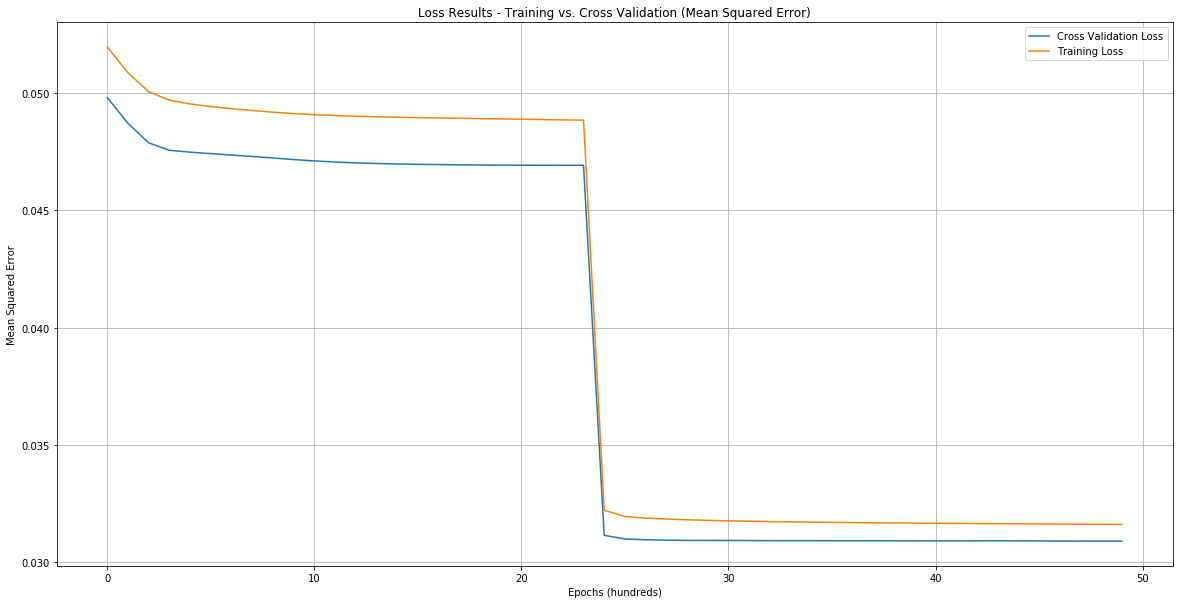

In [10]:
def show_loss(history):
    print("Last Results loss:{}, cross validation loss:{}".format(history.history['loss'][-1],history.history['val_loss'][-1]))
    training_loss=[history.history["loss"][x] for x in range(99,len(history.history["loss"])) if ((x+1) % 100) == 0]
    plt.figure(figsize=(20,10))
    plt.plot(history.history["val_loss"], label="Cross Validation Loss")
    plt.plot(training_loss, label="Training Loss")
    plt.xlabel("Epochs (hundreds)")
    plt.ylabel("Mean Squared Error")
    plt.title("Loss Results - Training vs. Cross Validation (Mean Squared Error)")
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()  
show_loss(history)

Our first test reproduces a strange behavior as the validation is better than the training. This could be one indicator of a bad model or an extreme underfitting situation. But be aware that we are using only a small dataset and we are using only 10% of the observations for testing. So it could be also a coincidence that the testing data fits better. Before starting with analyzing, we make a forecast with this model

#### Test the model with Forecasting

          Forecast : [411 387  47 447 474 523 622 615  47 439 408 432]
            Actual : [417 391 419 461 472 535 622 606 508 461 390 432]
Absolute Deviation : 920.3089370727539 Passengers
    Absolute Error : 18.95%


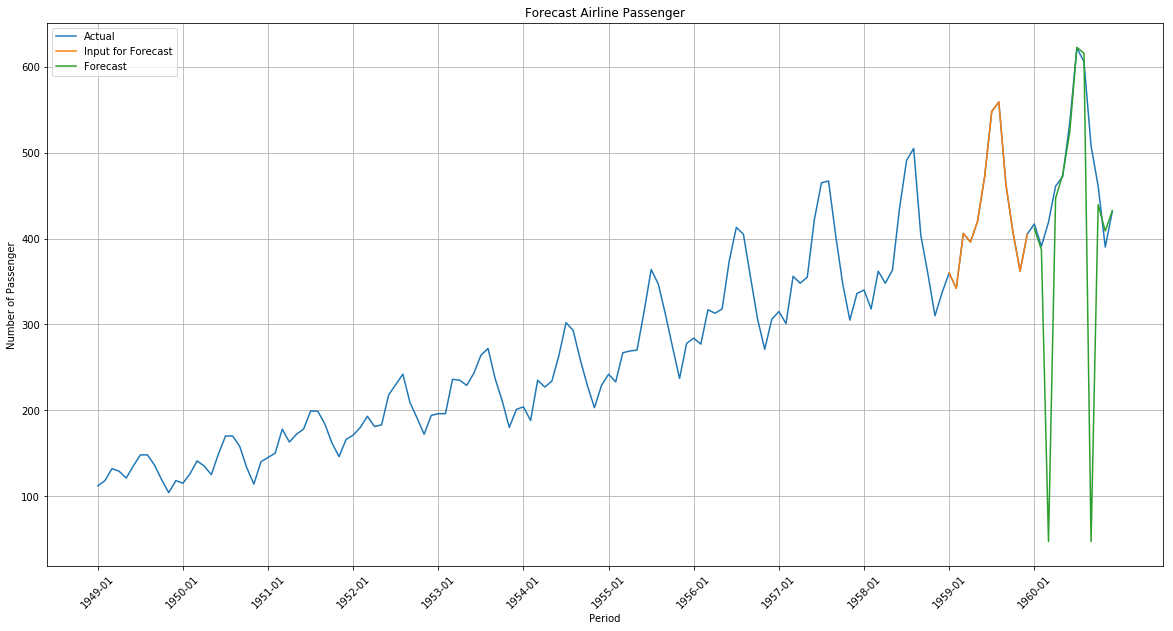

In [11]:
def show_results(df,predictX,predictY):
    outputsize=len(predictY[0])
    inputsize=len(predictX[0])
    absDeviation=np.sum(np.abs(df["Passengers"].values[-outputsize:]-predictY[0]))
    absError=absDeviation/np.sum(predictY[0])*100
    print("          Forecast : {}\r\n            Actual : {}\r\nAbsolute Deviation : {} Passengers\r\n    Absolute Error : {:3.2f}%".format(
        predictY.astype(int)[0],df["Passengers"].values[-outputsize:],absDeviation,absError))    
    y0=df["Passengers"].values
    y1=[None for x in range(df.shape[0]-outputsize-inputsize)]
    y1.extend(predictX[0])
    y1=np.array(y1)
    y2=[None for x in range(df.shape[0]-outputsize)]
    y2.extend(predictY[0])
    y2=np.array(y2)
    plt.figure(figsize=(20,10))
    plt.plot(y0,label='Actual')
    plt.plot(y1,label='Input for Forecast')
    plt.plot(y2, label= 'Forecast')
    plt.xlabel("Period")
    labels=[df["Period"].iloc[x] for x in range(0,df.shape[0],12)]
    plt.xticks(range(0,df.shape[0],12),labels=labels, rotation=45)
    plt.ylabel("Number of Passenger")
    plt.title("Forecast Airline Passenger")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.show()    

predictY=scaler.inverse_transform(model.predict(predictX))
show_results(df,scaler.inverse_transform(predictX),predictY)


As you can see in the chart above the quality in general is good but there are problems on march and September. These low values indicates death neurons. You can also find these death neurons by analyzing the last layer weights.


In [12]:
lastLayerIndex = len(model.layers) - 1
layerWeights = model.layers[lastLayerIndex].get_weights()[1]
print("Layerweights:{}".format(layerWeights))

Layerweights:[-0.00440797  0.02520173  0.          0.01670453  0.00712496 -0.00065792
  0.02046307  0.02631152  0.          0.02956164  0.03556152  0.04639733]


This is typical ReLU problem, if the weights and values on the hidden layer gets negativ, because then they will cut off. 
One solution is to try another activation function. 

#### Leaky ReLU

I had good experiences with leaky ReLU. With this activation function negative outcomes are still alive, but with a smaller sloop. The next model uses Leaky ReLU as activation function.


In [13]:
model1=keras.Sequential()
model1.add(keras.layers.Dense(37,activation=keras.layers.LeakyReLU(), input_dim=ts_input_size, use_bias=True))
model1.add(keras.layers.Dense(19,activation=keras.layers.LeakyReLU(), use_bias=True))
model1.add(keras.layers.Dense(ts_target_size, activation=keras.layers.LeakyReLU(), use_bias=True))

model1.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_squared_error']
)
history1=model1.fit(x_trainbatches, y_trainbatches, epochs=5000,
                               batch_size=len(x_trainbatches),
                               validation_data=(x_testbatches, y_testbatches),
                               validation_freq=100, 
                               use_multiprocessing=True)
predictY1=scaler.inverse_transform(model1.predict(predictX))

Epoch 1/5000
1/1 [==============================] - 0s 998us/step - loss: 0.1713 - mean_squared_error: 0.1713
Epoch 2/5000
1/1 [==============================] - 0s 0s/step - loss: 0.1655 - mean_squared_error: 0.1655
Epoch 3/5000
1/1 [==============================] - 0s 0s/step - loss: 0.1598 - mean_squared_error: 0.1598
Epoch 4/5000
1/1 [==============================] - 0s 0s/step - loss: 0.1543 - mean_squared_error: 0.1543
Epoch 5/5000
1/1 [==============================] - 0s 0s/step - loss: 0.1491 - mean_squared_error: 0.1491
Epoch 6/5000
1/1 [==============================] - 0s 0s/step - loss: 0.1442 - mean_squared_error: 0.1442
Epoch 7/5000
1/1 [==============================] - 0s 0s/step - loss: 0.1395 - mean_squared_error: 0.1395
Epoch 8/5000
1/1 [==============================] - 0s 0s/step - loss: 0.1350 - mean_squared_error: 0.1350
Epoch 9/5000
1/1 [==============================] - 0s 0s/step - loss: 0.1305 - mean_squared_error: 0.1305
Epoch 10/5000
1/1 [===============

1/1 [==============================] - 0s 0s/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 76/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 77/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 78/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 79/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 80/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 81/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 82/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 83/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 84/5000
1/1 [=======================

1/1 [==============================] - 0s 0s/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 150/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 151/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 152/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 153/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 154/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 155/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 156/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 157/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 158/5000
1/1 [============

1/1 [==============================] - 0s 0s/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 224/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 225/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 226/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 227/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 228/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 229/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 230/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 231/5000
1/1 [==============================] - 0s 10ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 232/5000
1/1 [==========

1/1 [==============================] - 0s 0s/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 298/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 299/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 300/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 301/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 302/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 303/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 304/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 305/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0037 - mean_sq

1/1 [==============================] - 0s 0s/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 372/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 373/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 374/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 375/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 376/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 377/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 378/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 379/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 380/5000
1/1 [==========

1/1 [==============================] - 0s 0s/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 446/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 447/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 448/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 449/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 450/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 451/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 452/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 453/5000
1/1 [==============================] - 0s 999us/step - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 454/5000
1/1 [===========

1/1 [==============================] - 0s 0s/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 520/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 521/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 522/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 523/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 524/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 525/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 526/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 527/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 528/5000
1/1 [===========

1/1 [==============================] - 0s 0s/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 595/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 596/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 597/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 598/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 599/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 600/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 601/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 602/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0017 - mean_sq

1/1 [==============================] - 0s 0s/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 669/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 670/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 671/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 672/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 673/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 674/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 675/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 676/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 677/5000
1/1 [============

1/1 [==============================] - 0s 0s/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 743/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 744/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 745/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 746/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 747/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 748/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 749/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 750/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 751/5000
1/1 [=============

1/1 [==============================] - 0s 2ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 817/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 818/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 819/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 820/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 821/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 822/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 823/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 824/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 825/5000
1/1 [===========

1/1 [==============================] - 0s 0s/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 892/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 893/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 894/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 895/5000
1/1 [==============================] - 0s 999us/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 896/5000
1/1 [==============================] - 0s 997us/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 897/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 898/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 899/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 900/5000
1/1 [========

1/1 [==============================] - 0s 0s/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 966/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 967/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 968/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 969/5000
1/1 [==============================] - 0s 15ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 970/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 971/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 972/5000
1/1 [==============================] - 0s 998us/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 973/5000
1/1 [==============================] - 0s 997us/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 974/5000
1/1 [====

1/1 [==============================] - 0s 0s/step - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 1040/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 1041/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 1042/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 1043/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 1044/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 1045/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 1046/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 1047/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 1048/5000
1/1 [=

1/1 [==============================] - 0s 0s/step - loss: 9.8827e-04 - mean_squared_error: 9.8827e-04
Epoch 1111/5000
1/1 [==============================] - 0s 0s/step - loss: 9.8786e-04 - mean_squared_error: 9.8786e-04
Epoch 1112/5000
1/1 [==============================] - 0s 0s/step - loss: 9.8745e-04 - mean_squared_error: 9.8745e-04
Epoch 1113/5000
1/1 [==============================] - 0s 0s/step - loss: 9.8703e-04 - mean_squared_error: 9.8703e-04
Epoch 1114/5000
1/1 [==============================] - 0s 0s/step - loss: 9.8663e-04 - mean_squared_error: 9.8663e-04
Epoch 1115/5000
1/1 [==============================] - 0s 0s/step - loss: 9.8622e-04 - mean_squared_error: 9.8622e-04
Epoch 1116/5000
1/1 [==============================] - 0s 0s/step - loss: 9.8581e-04 - mean_squared_error: 9.8581e-04
Epoch 1117/5000
1/1 [==============================] - 0s 0s/step - loss: 9.8541e-04 - mean_squared_error: 9.8541e-04
Epoch 1118/5000
1/1 [==============================] - 0s 16ms/step - lo

1/1 [==============================] - 0s 0s/step - loss: 9.6256e-04 - mean_squared_error: 9.6256e-04
Epoch 1180/5000
1/1 [==============================] - 0s 0s/step - loss: 9.6222e-04 - mean_squared_error: 9.6222e-04
Epoch 1181/5000
1/1 [==============================] - 0s 0s/step - loss: 9.6189e-04 - mean_squared_error: 9.6189e-04
Epoch 1182/5000
1/1 [==============================] - 0s 0s/step - loss: 9.6155e-04 - mean_squared_error: 9.6155e-04
Epoch 1183/5000
1/1 [==============================] - 0s 0s/step - loss: 9.6122e-04 - mean_squared_error: 9.6122e-04
Epoch 1184/5000
1/1 [==============================] - 0s 0s/step - loss: 9.6088e-04 - mean_squared_error: 9.6088e-04
Epoch 1185/5000
1/1 [==============================] - 0s 998us/step - loss: 9.6055e-04 - mean_squared_error: 9.6055e-04
Epoch 1186/5000
1/1 [==============================] - 0s 2ms/step - loss: 9.6022e-04 - mean_squared_error: 9.6022e-04
Epoch 1187/5000
1/1 [==============================] - 0s 999us/step

1/1 [==============================] - 0s 997us/step - loss: 9.4150e-04 - mean_squared_error: 9.4150e-04
Epoch 1248/5000
1/1 [==============================] - 0s 1ms/step - loss: 9.4122e-04 - mean_squared_error: 9.4122e-04
Epoch 1249/5000
1/1 [==============================] - 0s 0s/step - loss: 9.4094e-04 - mean_squared_error: 9.4094e-04
Epoch 1250/5000
1/1 [==============================] - 0s 1000us/step - loss: 9.4065e-04 - mean_squared_error: 9.4065e-04
Epoch 1251/5000
1/1 [==============================] - 0s 995us/step - loss: 9.4037e-04 - mean_squared_error: 9.4037e-04
Epoch 1252/5000
1/1 [==============================] - 0s 2ms/step - loss: 9.4009e-04 - mean_squared_error: 9.4009e-04
Epoch 1253/5000
1/1 [==============================] - 0s 999us/step - loss: 9.3981e-04 - mean_squared_error: 9.3981e-04
Epoch 1254/5000
1/1 [==============================] - 0s 998us/step - loss: 9.3953e-04 - mean_squared_error: 9.3953e-04
Epoch 1255/5000
1/1 [==============================] -

1/1 [==============================] - 0s 0s/step - loss: 9.2359e-04 - mean_squared_error: 9.2359e-04
Epoch 1315/5000
1/1 [==============================] - 0s 0s/step - loss: 9.2334e-04 - mean_squared_error: 9.2334e-04
Epoch 1316/5000
1/1 [==============================] - 0s 0s/step - loss: 9.2309e-04 - mean_squared_error: 9.2309e-04
Epoch 1317/5000
1/1 [==============================] - 0s 0s/step - loss: 9.2284e-04 - mean_squared_error: 9.2284e-04
Epoch 1318/5000
1/1 [==============================] - 0s 0s/step - loss: 9.2259e-04 - mean_squared_error: 9.2259e-04
Epoch 1319/5000
1/1 [==============================] - 0s 0s/step - loss: 9.2234e-04 - mean_squared_error: 9.2234e-04
Epoch 1320/5000
1/1 [==============================] - 0s 0s/step - loss: 9.2210e-04 - mean_squared_error: 9.2210e-04
Epoch 1321/5000
1/1 [==============================] - 0s 0s/step - loss: 9.2185e-04 - mean_squared_error: 9.2185e-04
Epoch 1322/5000
1/1 [==============================] - 0s 0s/step - loss

1/1 [==============================] - 0s 0s/step - loss: 9.0789e-04 - mean_squared_error: 9.0789e-04
Epoch 1383/5000
1/1 [==============================] - 0s 0s/step - loss: 9.0768e-04 - mean_squared_error: 9.0768e-04
Epoch 1384/5000
1/1 [==============================] - 0s 0s/step - loss: 9.0747e-04 - mean_squared_error: 9.0747e-04
Epoch 1385/5000
1/1 [==============================] - 0s 16ms/step - loss: 9.0726e-04 - mean_squared_error: 9.0726e-04
Epoch 1386/5000
1/1 [==============================] - 0s 0s/step - loss: 9.0705e-04 - mean_squared_error: 9.0705e-04
Epoch 1387/5000
1/1 [==============================] - 0s 0s/step - loss: 9.0684e-04 - mean_squared_error: 9.0684e-04
Epoch 1388/5000
1/1 [==============================] - 0s 0s/step - loss: 9.0663e-04 - mean_squared_error: 9.0663e-04
Epoch 1389/5000
1/1 [==============================] - 0s 0s/step - loss: 9.0642e-04 - mean_squared_error: 9.0642e-04
Epoch 1390/5000
1/1 [==============================] - 0s 0s/step - lo

1/1 [==============================] - 0s 0s/step - loss: 8.9428e-04 - mean_squared_error: 8.9428e-04
Epoch 1452/5000
1/1 [==============================] - 0s 0s/step - loss: 8.9409e-04 - mean_squared_error: 8.9409e-04
Epoch 1453/5000
1/1 [==============================] - 0s 0s/step - loss: 8.9391e-04 - mean_squared_error: 8.9391e-04
Epoch 1454/5000
1/1 [==============================] - 0s 0s/step - loss: 8.9373e-04 - mean_squared_error: 8.9373e-04
Epoch 1455/5000
1/1 [==============================] - 0s 0s/step - loss: 8.9354e-04 - mean_squared_error: 8.9354e-04
Epoch 1456/5000
1/1 [==============================] - 0s 1ms/step - loss: 8.9336e-04 - mean_squared_error: 8.9336e-04
Epoch 1457/5000
1/1 [==============================] - 0s 1ms/step - loss: 8.9318e-04 - mean_squared_error: 8.9318e-04
Epoch 1458/5000
1/1 [==============================] - 0s 0s/step - loss: 8.9299e-04 - mean_squared_error: 8.9299e-04
Epoch 1459/5000
1/1 [==============================] - 0s 0s/step - lo

Epoch 1520/5000
1/1 [==============================] - 0s 0s/step - loss: 8.8230e-04 - mean_squared_error: 8.8230e-04
Epoch 1521/5000
1/1 [==============================] - 0s 0s/step - loss: 8.8214e-04 - mean_squared_error: 8.8214e-04
Epoch 1522/5000
1/1 [==============================] - 0s 0s/step - loss: 8.8197e-04 - mean_squared_error: 8.8197e-04
Epoch 1523/5000
1/1 [==============================] - 0s 0s/step - loss: 8.8181e-04 - mean_squared_error: 8.8181e-04
Epoch 1524/5000
1/1 [==============================] - 0s 0s/step - loss: 8.8165e-04 - mean_squared_error: 8.8165e-04
Epoch 1525/5000
1/1 [==============================] - 0s 0s/step - loss: 8.8149e-04 - mean_squared_error: 8.8149e-04
Epoch 1526/5000
1/1 [==============================] - 0s 0s/step - loss: 8.8132e-04 - mean_squared_error: 8.8132e-04
Epoch 1527/5000
1/1 [==============================] - 0s 7ms/step - loss: 8.8116e-04 - mean_squared_error: 8.8116e-04
Epoch 1528/5000
1/1 [==============================] - 

1/1 [==============================] - 0s 997us/step - loss: 8.7155e-04 - mean_squared_error: 8.7155e-04
Epoch 1590/5000
1/1 [==============================] - 0s 0s/step - loss: 8.7140e-04 - mean_squared_error: 8.7140e-04
Epoch 1591/5000
1/1 [==============================] - 0s 0s/step - loss: 8.7125e-04 - mean_squared_error: 8.7125e-04
Epoch 1592/5000
1/1 [==============================] - 0s 1ms/step - loss: 8.7111e-04 - mean_squared_error: 8.7111e-04
Epoch 1593/5000
1/1 [==============================] - 0s 998us/step - loss: 8.7096e-04 - mean_squared_error: 8.7096e-04
Epoch 1594/5000
1/1 [==============================] - 0s 1ms/step - loss: 8.7081e-04 - mean_squared_error: 8.7081e-04
Epoch 1595/5000
1/1 [==============================] - 0s 2ms/step - loss: 8.7066e-04 - mean_squared_error: 8.7066e-04
Epoch 1596/5000
1/1 [==============================] - 0s 1ms/step - loss: 8.7051e-04 - mean_squared_error: 8.7051e-04
Epoch 1597/5000
1/1 [==============================] - 0s 999u

1/1 [==============================] - 0s 0s/step - loss: 8.6181e-04 - mean_squared_error: 8.6181e-04
Epoch 1658/5000
1/1 [==============================] - 0s 999us/step - loss: 8.6167e-04 - mean_squared_error: 8.6167e-04
Epoch 1659/5000
1/1 [==============================] - 0s 1000us/step - loss: 8.6153e-04 - mean_squared_error: 8.6153e-04
Epoch 1660/5000
1/1 [==============================] - 0s 1ms/step - loss: 8.6140e-04 - mean_squared_error: 8.6140e-04
Epoch 1661/5000
1/1 [==============================] - 0s 1ms/step - loss: 8.6126e-04 - mean_squared_error: 8.6126e-04
Epoch 1662/5000
1/1 [==============================] - 0s 999us/step - loss: 8.6112e-04 - mean_squared_error: 8.6112e-04
Epoch 1663/5000
1/1 [==============================] - 0s 1ms/step - loss: 8.6099e-04 - mean_squared_error: 8.6099e-04
Epoch 1664/5000
1/1 [==============================] - 0s 999us/step - loss: 8.6085e-04 - mean_squared_error: 8.6085e-04
Epoch 1665/5000
1/1 [==============================] - 0

1/1 [==============================] - 0s 0s/step - loss: 8.5285e-04 - mean_squared_error: 8.5285e-04
Epoch 1726/5000
1/1 [==============================] - 0s 0s/step - loss: 8.5272e-04 - mean_squared_error: 8.5272e-04
Epoch 1727/5000
1/1 [==============================] - 0s 0s/step - loss: 8.5259e-04 - mean_squared_error: 8.5259e-04
Epoch 1728/5000
1/1 [==============================] - 0s 0s/step - loss: 8.5247e-04 - mean_squared_error: 8.5247e-04
Epoch 1729/5000
1/1 [==============================] - 0s 0s/step - loss: 8.5234e-04 - mean_squared_error: 8.5234e-04
Epoch 1730/5000
1/1 [==============================] - 0s 0s/step - loss: 8.5222e-04 - mean_squared_error: 8.5222e-04
Epoch 1731/5000
1/1 [==============================] - 0s 0s/step - loss: 8.5209e-04 - mean_squared_error: 8.5209e-04
Epoch 1732/5000
1/1 [==============================] - 0s 0s/step - loss: 8.5196e-04 - mean_squared_error: 8.5196e-04
Epoch 1733/5000
1/1 [==============================] - 0s 0s/step - loss

1/1 [==============================] - 0s 2ms/step - loss: 8.4432e-04 - mean_squared_error: 8.4432e-04
Epoch 1795/5000
1/1 [==============================] - 0s 0s/step - loss: 8.4419e-04 - mean_squared_error: 8.4419e-04
Epoch 1796/5000
1/1 [==============================] - 0s 0s/step - loss: 8.4407e-04 - mean_squared_error: 8.4407e-04
Epoch 1797/5000
1/1 [==============================] - 0s 0s/step - loss: 8.4395e-04 - mean_squared_error: 8.4395e-04
Epoch 1798/5000
1/1 [==============================] - 0s 0s/step - loss: 8.4383e-04 - mean_squared_error: 8.4383e-04
Epoch 1799/5000
1/1 [==============================] - 0s 0s/step - loss: 8.4371e-04 - mean_squared_error: 8.4371e-04
Epoch 1800/5000
1/1 [==============================] - 0s 17ms/step - loss: 8.4359e-04 - mean_squared_error: 8.4359e-04 - val_loss: 9.5349e-04 - val_mean_squared_error: 9.5349e-04
Epoch 1801/5000
1/1 [==============================] - 0s 0s/step - loss: 8.4347e-04 - mean_squared_error: 8.4347e-04
Epoch 180

1/1 [==============================] - 0s 0s/step - loss: 8.3637e-04 - mean_squared_error: 8.3637e-04
Epoch 1863/5000
1/1 [==============================] - 0s 0s/step - loss: 8.3626e-04 - mean_squared_error: 8.3626e-04
Epoch 1864/5000
1/1 [==============================] - 0s 0s/step - loss: 8.3614e-04 - mean_squared_error: 8.3614e-04
Epoch 1865/5000
1/1 [==============================] - 0s 0s/step - loss: 8.3603e-04 - mean_squared_error: 8.3603e-04
Epoch 1866/5000
1/1 [==============================] - 0s 0s/step - loss: 8.3592e-04 - mean_squared_error: 8.3592e-04
Epoch 1867/5000
1/1 [==============================] - 0s 0s/step - loss: 8.3580e-04 - mean_squared_error: 8.3580e-04
Epoch 1868/5000
1/1 [==============================] - 0s 0s/step - loss: 8.3569e-04 - mean_squared_error: 8.3569e-04
Epoch 1869/5000
1/1 [==============================] - 0s 0s/step - loss: 8.3558e-04 - mean_squared_error: 8.3558e-04
Epoch 1870/5000
1/1 [==============================] - 0s 0s/step - loss

1/1 [==============================] - 0s 0s/step - loss: 8.2881e-04 - mean_squared_error: 8.2881e-04
Epoch 1931/5000
1/1 [==============================] - 0s 0s/step - loss: 8.2870e-04 - mean_squared_error: 8.2870e-04
Epoch 1932/5000
1/1 [==============================] - 0s 0s/step - loss: 8.2859e-04 - mean_squared_error: 8.2859e-04
Epoch 1933/5000
1/1 [==============================] - 0s 0s/step - loss: 8.2849e-04 - mean_squared_error: 8.2849e-04
Epoch 1934/5000
1/1 [==============================] - 0s 0s/step - loss: 8.2838e-04 - mean_squared_error: 8.2838e-04
Epoch 1935/5000
1/1 [==============================] - 0s 2ms/step - loss: 8.2827e-04 - mean_squared_error: 8.2827e-04
Epoch 1936/5000
1/1 [==============================] - 0s 2ms/step - loss: 8.2816e-04 - mean_squared_error: 8.2816e-04
Epoch 1937/5000
1/1 [==============================] - 0s 995us/step - loss: 8.2805e-04 - mean_squared_error: 8.2805e-04
Epoch 1938/5000
1/1 [==============================] - 0s 0s/step -

1/1 [==============================] - 0s 0s/step - loss: 8.2143e-04 - mean_squared_error: 8.2143e-04
Epoch 2000/5000
1/1 [==============================] - 0s 22ms/step - loss: 8.2132e-04 - mean_squared_error: 8.2132e-04 - val_loss: 9.3068e-04 - val_mean_squared_error: 9.3068e-04
Epoch 2001/5000
1/1 [==============================] - 0s 0s/step - loss: 8.2121e-04 - mean_squared_error: 8.2121e-04
Epoch 2002/5000
1/1 [==============================] - 0s 0s/step - loss: 8.2111e-04 - mean_squared_error: 8.2111e-04
Epoch 2003/5000
1/1 [==============================] - 0s 16ms/step - loss: 8.2100e-04 - mean_squared_error: 8.2100e-04
Epoch 2004/5000
1/1 [==============================] - 0s 0s/step - loss: 8.2090e-04 - mean_squared_error: 8.2090e-04
Epoch 2005/5000
1/1 [==============================] - 0s 0s/step - loss: 8.2079e-04 - mean_squared_error: 8.2079e-04
Epoch 2006/5000
1/1 [==============================] - 0s 0s/step - loss: 8.2069e-04 - mean_squared_error: 8.2069e-04
Epoch 20

1/1 [==============================] - 0s 1ms/step - loss: 8.1435e-04 - mean_squared_error: 8.1435e-04
Epoch 2068/5000
1/1 [==============================] - 0s 998us/step - loss: 8.1425e-04 - mean_squared_error: 8.1425e-04
Epoch 2069/5000
1/1 [==============================] - 0s 996us/step - loss: 8.1414e-04 - mean_squared_error: 8.1414e-04
Epoch 2070/5000
1/1 [==============================] - 0s 1ms/step - loss: 8.1404e-04 - mean_squared_error: 8.1404e-04
Epoch 2071/5000
1/1 [==============================] - 0s 1ms/step - loss: 8.1394e-04 - mean_squared_error: 8.1394e-04
Epoch 2072/5000
1/1 [==============================] - 0s 0s/step - loss: 8.1384e-04 - mean_squared_error: 8.1384e-04
Epoch 2073/5000
1/1 [==============================] - 0s 0s/step - loss: 8.1374e-04 - mean_squared_error: 8.1374e-04
Epoch 2074/5000
1/1 [==============================] - 0s 0s/step - loss: 8.1363e-04 - mean_squared_error: 8.1363e-04
Epoch 2075/5000
1/1 [==============================] - 0s 0s/st

1/1 [==============================] - 0s 0s/step - loss: 8.0746e-04 - mean_squared_error: 8.0746e-04
Epoch 2136/5000
1/1 [==============================] - 0s 0s/step - loss: 8.0736e-04 - mean_squared_error: 8.0736e-04
Epoch 2137/5000
1/1 [==============================] - 0s 0s/step - loss: 8.0726e-04 - mean_squared_error: 8.0726e-04
Epoch 2138/5000
1/1 [==============================] - 0s 0s/step - loss: 8.0716e-04 - mean_squared_error: 8.0716e-04
Epoch 2139/5000
1/1 [==============================] - 0s 0s/step - loss: 8.0706e-04 - mean_squared_error: 8.0706e-04
Epoch 2140/5000
1/1 [==============================] - 0s 0s/step - loss: 8.0696e-04 - mean_squared_error: 8.0696e-04
Epoch 2141/5000
1/1 [==============================] - 0s 16ms/step - loss: 8.0686e-04 - mean_squared_error: 8.0686e-04
Epoch 2142/5000
1/1 [==============================] - 0s 0s/step - loss: 8.0676e-04 - mean_squared_error: 8.0676e-04
Epoch 2143/5000
1/1 [==============================] - 0s 0s/step - lo

1/1 [==============================] - 0s 0s/step - loss: 8.0069e-04 - mean_squared_error: 8.0069e-04
Epoch 2204/5000
1/1 [==============================] - 0s 0s/step - loss: 8.0059e-04 - mean_squared_error: 8.0059e-04
Epoch 2205/5000
1/1 [==============================] - 0s 0s/step - loss: 8.0049e-04 - mean_squared_error: 8.0049e-04
Epoch 2206/5000
1/1 [==============================] - 0s 0s/step - loss: 8.0039e-04 - mean_squared_error: 8.0039e-04
Epoch 2207/5000
1/1 [==============================] - 0s 0s/step - loss: 8.0029e-04 - mean_squared_error: 8.0029e-04
Epoch 2208/5000
1/1 [==============================] - 0s 0s/step - loss: 8.0019e-04 - mean_squared_error: 8.0019e-04
Epoch 2209/5000
1/1 [==============================] - 0s 16ms/step - loss: 8.0009e-04 - mean_squared_error: 8.0009e-04
Epoch 2210/5000
1/1 [==============================] - 0s 0s/step - loss: 8.0000e-04 - mean_squared_error: 8.0000e-04
Epoch 2211/5000
1/1 [==============================] - 0s 0s/step - lo

1/1 [==============================] - 0s 0s/step - loss: 7.9391e-04 - mean_squared_error: 7.9391e-04
Epoch 2273/5000
1/1 [==============================] - 0s 0s/step - loss: 7.9381e-04 - mean_squared_error: 7.9381e-04
Epoch 2274/5000
1/1 [==============================] - 0s 0s/step - loss: 7.9371e-04 - mean_squared_error: 7.9371e-04
Epoch 2275/5000
1/1 [==============================] - 0s 0s/step - loss: 7.9361e-04 - mean_squared_error: 7.9361e-04
Epoch 2276/5000
1/1 [==============================] - 0s 0s/step - loss: 7.9351e-04 - mean_squared_error: 7.9351e-04
Epoch 2277/5000
1/1 [==============================] - 0s 0s/step - loss: 7.9342e-04 - mean_squared_error: 7.9342e-04
Epoch 2278/5000
1/1 [==============================] - 0s 0s/step - loss: 7.9332e-04 - mean_squared_error: 7.9332e-04
Epoch 2279/5000
1/1 [==============================] - 0s 0s/step - loss: 7.9322e-04 - mean_squared_error: 7.9322e-04
Epoch 2280/5000
1/1 [==============================] - 0s 0s/step - loss

1/1 [==============================] - 0s 16ms/step - loss: 7.8729e-04 - mean_squared_error: 7.8729e-04
Epoch 2341/5000
1/1 [==============================] - 0s 0s/step - loss: 7.8719e-04 - mean_squared_error: 7.8719e-04
Epoch 2342/5000
1/1 [==============================] - 0s 0s/step - loss: 7.8710e-04 - mean_squared_error: 7.8710e-04
Epoch 2343/5000
1/1 [==============================] - 0s 0s/step - loss: 7.8700e-04 - mean_squared_error: 7.8700e-04
Epoch 2344/5000
1/1 [==============================] - 0s 16ms/step - loss: 7.8690e-04 - mean_squared_error: 7.8690e-04
Epoch 2345/5000
1/1 [==============================] - 0s 0s/step - loss: 7.8681e-04 - mean_squared_error: 7.8681e-04
Epoch 2346/5000
1/1 [==============================] - 0s 0s/step - loss: 7.8671e-04 - mean_squared_error: 7.8671e-04
Epoch 2347/5000
1/1 [==============================] - 0s 0s/step - loss: 7.8661e-04 - mean_squared_error: 7.8661e-04
Epoch 2348/5000
1/1 [==============================] - 0s 0s/step - 

1/1 [==============================] - 0s 0s/step - loss: 7.8072e-04 - mean_squared_error: 7.8072e-04
Epoch 2409/5000
1/1 [==============================] - 0s 0s/step - loss: 7.8062e-04 - mean_squared_error: 7.8062e-04
Epoch 2410/5000
1/1 [==============================] - 0s 0s/step - loss: 7.8053e-04 - mean_squared_error: 7.8053e-04
Epoch 2411/5000
1/1 [==============================] - 0s 0s/step - loss: 7.8043e-04 - mean_squared_error: 7.8043e-04
Epoch 2412/5000
1/1 [==============================] - 0s 0s/step - loss: 7.8033e-04 - mean_squared_error: 7.8033e-04
Epoch 2413/5000
1/1 [==============================] - 0s 16ms/step - loss: 7.8024e-04 - mean_squared_error: 7.8024e-04
Epoch 2414/5000
1/1 [==============================] - 0s 998us/step - loss: 7.8014e-04 - mean_squared_error: 7.8014e-04
Epoch 2415/5000
1/1 [==============================] - 0s 0s/step - loss: 7.8005e-04 - mean_squared_error: 7.8005e-04
Epoch 2416/5000
1/1 [==============================] - 0s 1ms/step 

1/1 [==============================] - 0s 0s/step - loss: 7.7410e-04 - mean_squared_error: 7.7410e-04
Epoch 2478/5000
1/1 [==============================] - 0s 0s/step - loss: 7.7401e-04 - mean_squared_error: 7.7401e-04
Epoch 2479/5000
1/1 [==============================] - 0s 0s/step - loss: 7.7391e-04 - mean_squared_error: 7.7391e-04
Epoch 2480/5000
1/1 [==============================] - 0s 0s/step - loss: 7.7381e-04 - mean_squared_error: 7.7381e-04
Epoch 2481/5000
1/1 [==============================] - 0s 0s/step - loss: 7.7372e-04 - mean_squared_error: 7.7372e-04
Epoch 2482/5000
1/1 [==============================] - 0s 0s/step - loss: 7.7362e-04 - mean_squared_error: 7.7362e-04
Epoch 2483/5000
1/1 [==============================] - 0s 0s/step - loss: 7.7353e-04 - mean_squared_error: 7.7353e-04
Epoch 2484/5000
1/1 [==============================] - 0s 0s/step - loss: 7.7343e-04 - mean_squared_error: 7.7343e-04
Epoch 2485/5000
1/1 [==============================] - 0s 0s/step - loss

1/1 [==============================] - 0s 0s/step - loss: 7.6761e-04 - mean_squared_error: 7.6761e-04
Epoch 2546/5000
1/1 [==============================] - 0s 0s/step - loss: 7.6752e-04 - mean_squared_error: 7.6752e-04
Epoch 2547/5000
1/1 [==============================] - 0s 0s/step - loss: 7.6742e-04 - mean_squared_error: 7.6742e-04
Epoch 2548/5000
1/1 [==============================] - 0s 0s/step - loss: 7.6733e-04 - mean_squared_error: 7.6733e-04
Epoch 2549/5000
1/1 [==============================] - 0s 0s/step - loss: 7.6723e-04 - mean_squared_error: 7.6723e-04
Epoch 2550/5000
1/1 [==============================] - 0s 0s/step - loss: 7.6714e-04 - mean_squared_error: 7.6714e-04
Epoch 2551/5000
1/1 [==============================] - 0s 0s/step - loss: 7.6704e-04 - mean_squared_error: 7.6704e-04
Epoch 2552/5000
1/1 [==============================] - 0s 0s/step - loss: 7.6695e-04 - mean_squared_error: 7.6695e-04
Epoch 2553/5000
1/1 [==============================] - 0s 0s/step - loss

Epoch 2614/5000
1/1 [==============================] - 0s 0s/step - loss: 7.6105e-04 - mean_squared_error: 7.6105e-04
Epoch 2615/5000
1/1 [==============================] - 0s 0s/step - loss: 7.6096e-04 - mean_squared_error: 7.6096e-04
Epoch 2616/5000
1/1 [==============================] - 0s 0s/step - loss: 7.6086e-04 - mean_squared_error: 7.6086e-04
Epoch 2617/5000
1/1 [==============================] - 0s 0s/step - loss: 7.6077e-04 - mean_squared_error: 7.6077e-04
Epoch 2618/5000
1/1 [==============================] - 0s 0s/step - loss: 7.6067e-04 - mean_squared_error: 7.6067e-04
Epoch 2619/5000
1/1 [==============================] - 0s 16ms/step - loss: 7.6058e-04 - mean_squared_error: 7.6058e-04
Epoch 2620/5000
1/1 [==============================] - 0s 0s/step - loss: 7.6048e-04 - mean_squared_error: 7.6048e-04
Epoch 2621/5000
1/1 [==============================] - 0s 0s/step - loss: 7.6039e-04 - mean_squared_error: 7.6039e-04
Epoch 2622/5000
1/1 [==============================] -

1/1 [==============================] - 0s 16ms/step - loss: 7.5451e-04 - mean_squared_error: 7.5451e-04
Epoch 2684/5000
1/1 [==============================] - 0s 0s/step - loss: 7.5442e-04 - mean_squared_error: 7.5442e-04
Epoch 2685/5000
1/1 [==============================] - 0s 0s/step - loss: 7.5432e-04 - mean_squared_error: 7.5432e-04
Epoch 2686/5000
1/1 [==============================] - 0s 0s/step - loss: 7.5422e-04 - mean_squared_error: 7.5422e-04
Epoch 2687/5000
1/1 [==============================] - 0s 16ms/step - loss: 7.5413e-04 - mean_squared_error: 7.5413e-04
Epoch 2688/5000
1/1 [==============================] - 0s 0s/step - loss: 7.5404e-04 - mean_squared_error: 7.5404e-04
Epoch 2689/5000
1/1 [==============================] - 0s 0s/step - loss: 7.5394e-04 - mean_squared_error: 7.5394e-04
Epoch 2690/5000
1/1 [==============================] - 0s 0s/step - loss: 7.5385e-04 - mean_squared_error: 7.5385e-04
Epoch 2691/5000
1/1 [==============================] - 0s 16ms/step 

1/1 [==============================] - 0s 0s/step - loss: 7.4807e-04 - mean_squared_error: 7.4807e-04
Epoch 2752/5000
1/1 [==============================] - 0s 0s/step - loss: 7.4798e-04 - mean_squared_error: 7.4798e-04
Epoch 2753/5000
1/1 [==============================] - 0s 16ms/step - loss: 7.4789e-04 - mean_squared_error: 7.4789e-04
Epoch 2754/5000
1/1 [==============================] - 0s 0s/step - loss: 7.4779e-04 - mean_squared_error: 7.4779e-04
Epoch 2755/5000
1/1 [==============================] - 0s 0s/step - loss: 7.4770e-04 - mean_squared_error: 7.4770e-04
Epoch 2756/5000
1/1 [==============================] - 0s 0s/step - loss: 7.4761e-04 - mean_squared_error: 7.4761e-04
Epoch 2757/5000
1/1 [==============================] - 0s 0s/step - loss: 7.4751e-04 - mean_squared_error: 7.4751e-04
Epoch 2758/5000
1/1 [==============================] - 0s 0s/step - loss: 7.4741e-04 - mean_squared_error: 7.4741e-04
Epoch 2759/5000
1/1 [==============================] - 0s 0s/step - lo

1/1 [==============================] - 0s 0s/step - loss: 7.4163e-04 - mean_squared_error: 7.4163e-04
Epoch 2820/5000
1/1 [==============================] - 0s 0s/step - loss: 7.4153e-04 - mean_squared_error: 7.4153e-04
Epoch 2821/5000
1/1 [==============================] - 0s 7ms/step - loss: 7.4143e-04 - mean_squared_error: 7.4143e-04
Epoch 2822/5000
1/1 [==============================] - 0s 0s/step - loss: 7.4134e-04 - mean_squared_error: 7.4134e-04
Epoch 2823/5000
1/1 [==============================] - 0s 0s/step - loss: 7.4125e-04 - mean_squared_error: 7.4125e-04
Epoch 2824/5000
1/1 [==============================] - 0s 0s/step - loss: 7.4115e-04 - mean_squared_error: 7.4115e-04
Epoch 2825/5000
1/1 [==============================] - 0s 16ms/step - loss: 7.4105e-04 - mean_squared_error: 7.4105e-04
Epoch 2826/5000
1/1 [==============================] - 0s 0s/step - loss: 7.4096e-04 - mean_squared_error: 7.4096e-04
Epoch 2827/5000
1/1 [==============================] - 0s 0s/step - l

1/1 [==============================] - 0s 0s/step - loss: 7.3518e-04 - mean_squared_error: 7.3518e-04
Epoch 2888/5000
1/1 [==============================] - 0s 0s/step - loss: 7.3508e-04 - mean_squared_error: 7.3508e-04
Epoch 2889/5000
1/1 [==============================] - 0s 0s/step - loss: 7.3499e-04 - mean_squared_error: 7.3499e-04
Epoch 2890/5000
1/1 [==============================] - 0s 0s/step - loss: 7.3489e-04 - mean_squared_error: 7.3489e-04
Epoch 2891/5000
1/1 [==============================] - 0s 0s/step - loss: 7.3480e-04 - mean_squared_error: 7.3480e-04
Epoch 2892/5000
1/1 [==============================] - 0s 0s/step - loss: 7.3470e-04 - mean_squared_error: 7.3470e-04
Epoch 2893/5000
1/1 [==============================] - 0s 0s/step - loss: 7.3460e-04 - mean_squared_error: 7.3460e-04
Epoch 2894/5000
1/1 [==============================] - 0s 0s/step - loss: 7.3451e-04 - mean_squared_error: 7.3451e-04
Epoch 2895/5000
1/1 [==============================] - 0s 16ms/step - lo

1/1 [==============================] - 0s 0s/step - loss: 7.2872e-04 - mean_squared_error: 7.2872e-04
Epoch 2956/5000
1/1 [==============================] - 0s 0s/step - loss: 7.2864e-04 - mean_squared_error: 7.2864e-04
Epoch 2957/5000
1/1 [==============================] - 0s 0s/step - loss: 7.2853e-04 - mean_squared_error: 7.2853e-04
Epoch 2958/5000
1/1 [==============================] - 0s 0s/step - loss: 7.2845e-04 - mean_squared_error: 7.2845e-04
Epoch 2959/5000
1/1 [==============================] - ETA: 0s - loss: 7.2835e-04 - mean_squared_error: 7.2835e- - 0s 0s/step - loss: 7.2835e-04 - mean_squared_error: 7.2835e-04
Epoch 2960/5000
1/1 [==============================] - 0s 0s/step - loss: 7.2825e-04 - mean_squared_error: 7.2825e-04
Epoch 2961/5000
1/1 [==============================] - 0s 0s/step - loss: 7.2816e-04 - mean_squared_error: 7.2816e-04
Epoch 2962/5000
1/1 [==============================] - 0s 0s/step - loss: 7.2807e-04 - mean_squared_error: 7.2807e-04
Epoch 2963/5

1/1 [==============================] - 0s 0s/step - loss: 7.2227e-04 - mean_squared_error: 7.2227e-04
Epoch 3024/5000
1/1 [==============================] - 0s 0s/step - loss: 7.2219e-04 - mean_squared_error: 7.2219e-04
Epoch 3025/5000
1/1 [==============================] - 0s 0s/step - loss: 7.2209e-04 - mean_squared_error: 7.2209e-04
Epoch 3026/5000
1/1 [==============================] - 0s 0s/step - loss: 7.2200e-04 - mean_squared_error: 7.2200e-04
Epoch 3027/5000
1/1 [==============================] - 0s 998us/step - loss: 7.2191e-04 - mean_squared_error: 7.2191e-04
Epoch 3028/5000
1/1 [==============================] - 0s 2ms/step - loss: 7.2180e-04 - mean_squared_error: 7.2180e-04
Epoch 3029/5000
1/1 [==============================] - 0s 998us/step - loss: 7.2172e-04 - mean_squared_error: 7.2172e-04
Epoch 3030/5000
1/1 [==============================] - 0s 0s/step - loss: 7.2160e-04 - mean_squared_error: 7.2160e-04
Epoch 3031/5000
1/1 [==============================] - 0s 0s/step

1/1 [==============================] - 0s 0s/step - loss: 7.1575e-04 - mean_squared_error: 7.1575e-04
Epoch 3093/5000
1/1 [==============================] - 0s 0s/step - loss: 7.1567e-04 - mean_squared_error: 7.1567e-04
Epoch 3094/5000
1/1 [==============================] - 0s 0s/step - loss: 7.1557e-04 - mean_squared_error: 7.1557e-04
Epoch 3095/5000
1/1 [==============================] - 0s 0s/step - loss: 7.1546e-04 - mean_squared_error: 7.1546e-04
Epoch 3096/5000
1/1 [==============================] - 0s 0s/step - loss: 7.1536e-04 - mean_squared_error: 7.1536e-04
Epoch 3097/5000
1/1 [==============================] - 0s 0s/step - loss: 7.1529e-04 - mean_squared_error: 7.1529e-04
Epoch 3098/5000
1/1 [==============================] - 0s 0s/step - loss: 7.1518e-04 - mean_squared_error: 7.1518e-04
Epoch 3099/5000
1/1 [==============================] - 0s 16ms/step - loss: 7.1508e-04 - mean_squared_error: 7.1508e-04
Epoch 3100/5000
1/1 [==============================] - 0s 16ms/step - 

1/1 [==============================] - 0s 0s/step - loss: 7.0931e-04 - mean_squared_error: 7.0931e-04
Epoch 3161/5000
1/1 [==============================] - 0s 0s/step - loss: 7.0921e-04 - mean_squared_error: 7.0921e-04
Epoch 3162/5000
1/1 [==============================] - 0s 16ms/step - loss: 7.0912e-04 - mean_squared_error: 7.0912e-04
Epoch 3163/5000
1/1 [==============================] - 0s 0s/step - loss: 7.0902e-04 - mean_squared_error: 7.0902e-04
Epoch 3164/5000
1/1 [==============================] - 0s 0s/step - loss: 7.0895e-04 - mean_squared_error: 7.0895e-04
Epoch 3165/5000
1/1 [==============================] - 0s 0s/step - loss: 7.0883e-04 - mean_squared_error: 7.0883e-04
Epoch 3166/5000
1/1 [==============================] - 0s 0s/step - loss: 7.0875e-04 - mean_squared_error: 7.0875e-04
Epoch 3167/5000
1/1 [==============================] - 0s 0s/step - loss: 7.0866e-04 - mean_squared_error: 7.0866e-04
Epoch 3168/5000
1/1 [==============================] - 0s 0s/step - lo

1/1 [==============================] - 0s 0s/step - loss: 7.0290e-04 - mean_squared_error: 7.0290e-04
Epoch 3229/5000
1/1 [==============================] - 0s 0s/step - loss: 7.0280e-04 - mean_squared_error: 7.0280e-04
Epoch 3230/5000
1/1 [==============================] - 0s 0s/step - loss: 7.0270e-04 - mean_squared_error: 7.0270e-04
Epoch 3231/5000
1/1 [==============================] - 0s 0s/step - loss: 7.0261e-04 - mean_squared_error: 7.0261e-04
Epoch 3232/5000
1/1 [==============================] - 0s 0s/step - loss: 7.0250e-04 - mean_squared_error: 7.0250e-04
Epoch 3233/5000
1/1 [==============================] - 0s 0s/step - loss: 7.0242e-04 - mean_squared_error: 7.0242e-04
Epoch 3234/5000
1/1 [==============================] - 0s 0s/step - loss: 7.0231e-04 - mean_squared_error: 7.0231e-04
Epoch 3235/5000
1/1 [==============================] - 0s 0s/step - loss: 7.0220e-04 - mean_squared_error: 7.0220e-04
Epoch 3236/5000
1/1 [==============================] - 0s 0s/step - loss

1/1 [==============================] - 0s 0s/step - loss: 6.9634e-04 - mean_squared_error: 6.9634e-04
Epoch 3298/5000
1/1 [==============================] - 0s 0s/step - loss: 6.9623e-04 - mean_squared_error: 6.9623e-04
Epoch 3299/5000
1/1 [==============================] - 0s 0s/step - loss: 6.9614e-04 - mean_squared_error: 6.9614e-04
Epoch 3300/5000
1/1 [==============================] - 0s 16ms/step - loss: 6.9604e-04 - mean_squared_error: 6.9604e-04 - val_loss: 8.2652e-04 - val_mean_squared_error: 8.2652e-04
Epoch 3301/5000
1/1 [==============================] - 0s 16ms/step - loss: 6.9595e-04 - mean_squared_error: 6.9595e-04
Epoch 3302/5000
1/1 [==============================] - 0s 0s/step - loss: 6.9586e-04 - mean_squared_error: 6.9586e-04
Epoch 3303/5000
1/1 [==============================] - 0s 0s/step - loss: 6.9578e-04 - mean_squared_error: 6.9578e-04
Epoch 3304/5000
1/1 [==============================] - 0s 0s/step - loss: 6.9567e-04 - mean_squared_error: 6.9567e-04
Epoch 33

1/1 [==============================] - 0s 0s/step - loss: 6.8985e-04 - mean_squared_error: 6.8985e-04
Epoch 3366/5000
1/1 [==============================] - 0s 0s/step - loss: 6.8977e-04 - mean_squared_error: 6.8977e-04
Epoch 3367/5000
1/1 [==============================] - 0s 0s/step - loss: 6.8969e-04 - mean_squared_error: 6.8969e-04
Epoch 3368/5000
1/1 [==============================] - 0s 0s/step - loss: 6.8958e-04 - mean_squared_error: 6.8958e-04
Epoch 3369/5000
1/1 [==============================] - 0s 0s/step - loss: 6.8950e-04 - mean_squared_error: 6.8950e-04
Epoch 3370/5000
1/1 [==============================] - 0s 0s/step - loss: 6.8939e-04 - mean_squared_error: 6.8939e-04
Epoch 3371/5000
1/1 [==============================] - 0s 0s/step - loss: 6.8928e-04 - mean_squared_error: 6.8928e-04
Epoch 3372/5000
1/1 [==============================] - 0s 0s/step - loss: 6.8920e-04 - mean_squared_error: 6.8920e-04
Epoch 3373/5000
1/1 [==============================] - 0s 0s/step - loss

1/1 [==============================] - 0s 0s/step - loss: 6.8332e-04 - mean_squared_error: 6.8332e-04
Epoch 3434/5000
1/1 [==============================] - 0s 0s/step - loss: 6.8321e-04 - mean_squared_error: 6.8321e-04
Epoch 3435/5000
1/1 [==============================] - 0s 0s/step - loss: 6.8313e-04 - mean_squared_error: 6.8313e-04
Epoch 3436/5000
1/1 [==============================] - 0s 0s/step - loss: 6.8303e-04 - mean_squared_error: 6.8303e-04
Epoch 3437/5000
1/1 [==============================] - 0s 0s/step - loss: 6.8291e-04 - mean_squared_error: 6.8291e-04
Epoch 3438/5000
1/1 [==============================] - 0s 0s/step - loss: 6.8284e-04 - mean_squared_error: 6.8284e-04
Epoch 3439/5000
1/1 [==============================] - 0s 0s/step - loss: 6.8271e-04 - mean_squared_error: 6.8271e-04
Epoch 3440/5000
1/1 [==============================] - 0s 0s/step - loss: 6.8263e-04 - mean_squared_error: 6.8263e-04
Epoch 3441/5000
1/1 [==============================] - 0s 0s/step - loss

Epoch 3502/5000
1/1 [==============================] - 0s 0s/step - loss: 6.7665e-04 - mean_squared_error: 6.7665e-04
Epoch 3503/5000
1/1 [==============================] - 0s 4ms/step - loss: 6.7654e-04 - mean_squared_error: 6.7654e-04
Epoch 3504/5000
1/1 [==============================] - 0s 0s/step - loss: 6.7647e-04 - mean_squared_error: 6.7647e-04
Epoch 3505/5000
1/1 [==============================] - 0s 0s/step - loss: 6.7635e-04 - mean_squared_error: 6.7635e-04
Epoch 3506/5000
1/1 [==============================] - 0s 0s/step - loss: 6.7627e-04 - mean_squared_error: 6.7627e-04
Epoch 3507/5000
1/1 [==============================] - 0s 0s/step - loss: 6.7618e-04 - mean_squared_error: 6.7618e-04
Epoch 3508/5000
1/1 [==============================] - 0s 0s/step - loss: 6.7605e-04 - mean_squared_error: 6.7605e-04
Epoch 3509/5000
1/1 [==============================] - 0s 0s/step - loss: 6.7599e-04 - mean_squared_error: 6.7599e-04
Epoch 3510/5000
1/1 [==============================] - 

1/1 [==============================] - 0s 16ms/step - loss: 6.6996e-04 - mean_squared_error: 6.6996e-04
Epoch 3572/5000
1/1 [==============================] - 0s 0s/step - loss: 6.6993e-04 - mean_squared_error: 6.6993e-04
Epoch 3573/5000
1/1 [==============================] - 0s 0s/step - loss: 6.6976e-04 - mean_squared_error: 6.6976e-04
Epoch 3574/5000
1/1 [==============================] - 0s 0s/step - loss: 6.6973e-04 - mean_squared_error: 6.6973e-04
Epoch 3575/5000
1/1 [==============================] - 0s 0s/step - loss: 6.6962e-04 - mean_squared_error: 6.6962e-04
Epoch 3576/5000
1/1 [==============================] - 0s 0s/step - loss: 6.6948e-04 - mean_squared_error: 6.6948e-04
Epoch 3577/5000
1/1 [==============================] - 0s 0s/step - loss: 6.6946e-04 - mean_squared_error: 6.6946e-04
Epoch 3578/5000
1/1 [==============================] - 0s 0s/step - loss: 6.6928e-04 - mean_squared_error: 6.6928e-04
Epoch 3579/5000
1/1 [==============================] - 0s 0s/step - lo

Epoch 3640/5000
1/1 [==============================] - 0s 0s/step - loss: 6.6324e-04 - mean_squared_error: 6.6324e-04
Epoch 3641/5000
1/1 [==============================] - 0s 0s/step - loss: 6.6320e-04 - mean_squared_error: 6.6320e-04
Epoch 3642/5000
1/1 [==============================] - 0s 0s/step - loss: 6.6305e-04 - mean_squared_error: 6.6305e-04
Epoch 3643/5000
1/1 [==============================] - 0s 0s/step - loss: 6.6301e-04 - mean_squared_error: 6.6301e-04
Epoch 3644/5000
1/1 [==============================] - 0s 1ms/step - loss: 6.6290e-04 - mean_squared_error: 6.6290e-04
Epoch 3645/5000
1/1 [==============================] - 0s 997us/step - loss: 6.6276e-04 - mean_squared_error: 6.6276e-04
Epoch 3646/5000
1/1 [==============================] - 0s 0s/step - loss: 6.6274e-04 - mean_squared_error: 6.6274e-04
Epoch 3647/5000
1/1 [==============================] - 0s 998us/step - loss: 6.6258e-04 - mean_squared_error: 6.6258e-04
Epoch 3648/5000
1/1 [============================

1/1 [==============================] - 0s 0s/step - loss: 6.5655e-04 - mean_squared_error: 6.5655e-04
Epoch 3709/5000
1/1 [==============================] - 0s 0s/step - loss: 6.5657e-04 - mean_squared_error: 6.5657e-04
Epoch 3710/5000
1/1 [==============================] - 0s 0s/step - loss: 6.5633e-04 - mean_squared_error: 6.5633e-04
Epoch 3711/5000
1/1 [==============================] - 0s 0s/step - loss: 6.5633e-04 - mean_squared_error: 6.5633e-04
Epoch 3712/5000
1/1 [==============================] - 0s 0s/step - loss: 6.5613e-04 - mean_squared_error: 6.5613e-04
Epoch 3713/5000
1/1 [==============================] - 0s 0s/step - loss: 6.5607e-04 - mean_squared_error: 6.5607e-04
Epoch 3714/5000
1/1 [==============================] - 0s 0s/step - loss: 6.5594e-04 - mean_squared_error: 6.5594e-04
Epoch 3715/5000
1/1 [==============================] - 0s 0s/step - loss: 6.5588e-04 - mean_squared_error: 6.5588e-04
Epoch 3716/5000
1/1 [==============================] - 0s 0s/step - loss

1/1 [==============================] - 0s 0s/step - loss: 6.4995e-04 - mean_squared_error: 6.4995e-04
Epoch 3778/5000
1/1 [==============================] - 0s 0s/step - loss: 6.4976e-04 - mean_squared_error: 6.4976e-04
Epoch 3779/5000
1/1 [==============================] - 0s 0s/step - loss: 6.4950e-04 - mean_squared_error: 6.4950e-04
Epoch 3780/5000
1/1 [==============================] - 0s 1ms/step - loss: 6.4961e-04 - mean_squared_error: 6.4961e-04
Epoch 3781/5000
1/1 [==============================] - 0s 0s/step - loss: 6.4948e-04 - mean_squared_error: 6.4948e-04
Epoch 3782/5000
1/1 [==============================] - 0s 0s/step - loss: 6.4925e-04 - mean_squared_error: 6.4925e-04
Epoch 3783/5000
1/1 [==============================] - 0s 0s/step - loss: 6.4918e-04 - mean_squared_error: 6.4918e-04
Epoch 3784/5000
1/1 [==============================] - 0s 0s/step - loss: 6.4909e-04 - mean_squared_error: 6.4909e-04
Epoch 3785/5000
1/1 [==============================] - 0s 0s/step - los

1/1 [==============================] - 0s 0s/step - loss: 6.4305e-04 - mean_squared_error: 6.4305e-04
Epoch 3846/5000
1/1 [==============================] - 0s 0s/step - loss: 6.4307e-04 - mean_squared_error: 6.4307e-04
Epoch 3847/5000
1/1 [==============================] - 0s 0s/step - loss: 6.4280e-04 - mean_squared_error: 6.4280e-04
Epoch 3848/5000
1/1 [==============================] - 0s 16ms/step - loss: 6.4257e-04 - mean_squared_error: 6.4257e-04
Epoch 3849/5000
1/1 [==============================] - 0s 0s/step - loss: 6.4254e-04 - mean_squared_error: 6.4254e-04
Epoch 3850/5000
1/1 [==============================] - 0s 0s/step - loss: 6.4245e-04 - mean_squared_error: 6.4245e-04
Epoch 3851/5000
1/1 [==============================] - 0s 0s/step - loss: 6.4232e-04 - mean_squared_error: 6.4232e-04
Epoch 3852/5000
1/1 [==============================] - 0s 0s/step - loss: 6.4221e-04 - mean_squared_error: 6.4221e-04
Epoch 3853/5000
1/1 [==============================] - 0s 0s/step - lo

1/1 [==============================] - 0s 0s/step - loss: 6.3496e-04 - mean_squared_error: 6.3496e-04
Epoch 3914/5000
1/1 [==============================] - 0s 0s/step - loss: 6.3485e-04 - mean_squared_error: 6.3485e-04
Epoch 3915/5000
1/1 [==============================] - 0s 0s/step - loss: 6.3477e-04 - mean_squared_error: 6.3477e-04
Epoch 3916/5000
1/1 [==============================] - 0s 0s/step - loss: 6.3467e-04 - mean_squared_error: 6.3467e-04
Epoch 3917/5000
1/1 [==============================] - 0s 16ms/step - loss: 6.3455e-04 - mean_squared_error: 6.3455e-04
Epoch 3918/5000
1/1 [==============================] - 0s 0s/step - loss: 6.3443e-04 - mean_squared_error: 6.3443e-04
Epoch 3919/5000
1/1 [==============================] - 0s 0s/step - loss: 6.3441e-04 - mean_squared_error: 6.3441e-04
Epoch 3920/5000
1/1 [==============================] - 0s 0s/step - loss: 6.3431e-04 - mean_squared_error: 6.3431e-04
Epoch 3921/5000
1/1 [==============================] - 0s 16ms/step - 

1/1 [==============================] - 0s 0s/step - loss: 6.2802e-04 - mean_squared_error: 6.2802e-04
Epoch 3983/5000
1/1 [==============================] - 0s 0s/step - loss: 6.2770e-04 - mean_squared_error: 6.2770e-04
Epoch 3984/5000
1/1 [==============================] - 0s 0s/step - loss: 6.2776e-04 - mean_squared_error: 6.2776e-04
Epoch 3985/5000
1/1 [==============================] - 0s 0s/step - loss: 6.2774e-04 - mean_squared_error: 6.2774e-04
Epoch 3986/5000
1/1 [==============================] - 0s 0s/step - loss: 6.2748e-04 - mean_squared_error: 6.2748e-04
Epoch 3987/5000
1/1 [==============================] - 0s 0s/step - loss: 6.2733e-04 - mean_squared_error: 6.2733e-04
Epoch 3988/5000
1/1 [==============================] - 0s 0s/step - loss: 6.2743e-04 - mean_squared_error: 6.2743e-04
Epoch 3989/5000
1/1 [==============================] - 0s 0s/step - loss: 6.2735e-04 - mean_squared_error: 6.2735e-04
Epoch 3990/5000
1/1 [==============================] - 0s 0s/step - loss

1/1 [==============================] - 0s 0s/step - loss: 6.2086e-04 - mean_squared_error: 6.2086e-04
Epoch 4051/5000
1/1 [==============================] - 0s 0s/step - loss: 6.2072e-04 - mean_squared_error: 6.2072e-04
Epoch 4052/5000
1/1 [==============================] - 0s 0s/step - loss: 6.2061e-04 - mean_squared_error: 6.2061e-04
Epoch 4053/5000
1/1 [==============================] - 0s 0s/step - loss: 6.2051e-04 - mean_squared_error: 6.2051e-04
Epoch 4054/5000
1/1 [==============================] - 0s 0s/step - loss: 6.2039e-04 - mean_squared_error: 6.2039e-04
Epoch 4055/5000
1/1 [==============================] - 0s 0s/step - loss: 6.2030e-04 - mean_squared_error: 6.2030e-04
Epoch 4056/5000
1/1 [==============================] - 0s 0s/step - loss: 6.2036e-04 - mean_squared_error: 6.2036e-04
Epoch 4057/5000
1/1 [==============================] - 0s 0s/step - loss: 6.2031e-04 - mean_squared_error: 6.2031e-04
Epoch 4058/5000
1/1 [==============================] - 0s 0s/step - loss

1/1 [==============================] - 0s 0s/step - loss: 6.1396e-04 - mean_squared_error: 6.1396e-04
Epoch 4119/5000
1/1 [==============================] - 0s 0s/step - loss: 6.1379e-04 - mean_squared_error: 6.1379e-04
Epoch 4120/5000
1/1 [==============================] - 0s 0s/step - loss: 6.1362e-04 - mean_squared_error: 6.1362e-04
Epoch 4121/5000
1/1 [==============================] - 0s 0s/step - loss: 6.1346e-04 - mean_squared_error: 6.1346e-04
Epoch 4122/5000
1/1 [==============================] - 0s 0s/step - loss: 6.1327e-04 - mean_squared_error: 6.1327e-04
Epoch 4123/5000
1/1 [==============================] - 0s 0s/step - loss: 6.1320e-04 - mean_squared_error: 6.1320e-04
Epoch 4124/5000
1/1 [==============================] - 0s 0s/step - loss: 6.1309e-04 - mean_squared_error: 6.1309e-04
Epoch 4125/5000
1/1 [==============================] - 0s 0s/step - loss: 6.1303e-04 - mean_squared_error: 6.1303e-04
Epoch 4126/5000
1/1 [==============================] - 0s 0s/step - loss

1/1 [==============================] - 0s 0s/step - loss: 6.1183e-04 - mean_squared_error: 6.1183e-04
Epoch 4188/5000
1/1 [==============================] - 0s 0s/step - loss: 6.0926e-04 - mean_squared_error: 6.0926e-04
Epoch 4189/5000
1/1 [==============================] - 0s 0s/step - loss: 6.0659e-04 - mean_squared_error: 6.0659e-04
Epoch 4190/5000
1/1 [==============================] - 0s 0s/step - loss: 6.0546e-04 - mean_squared_error: 6.0546e-04
Epoch 4191/5000
1/1 [==============================] - 0s 0s/step - loss: 6.0601e-04 - mean_squared_error: 6.0601e-04
Epoch 4192/5000
1/1 [==============================] - 0s 0s/step - loss: 6.0704e-04 - mean_squared_error: 6.0704e-04
Epoch 4193/5000
1/1 [==============================] - 0s 0s/step - loss: 6.0748e-04 - mean_squared_error: 6.0748e-04
Epoch 4194/5000
1/1 [==============================] - 0s 0s/step - loss: 6.0713e-04 - mean_squared_error: 6.0713e-04
Epoch 4195/5000
1/1 [==============================] - 0s 0s/step - loss

1/1 [==============================] - 0s 999us/step - loss: 5.9874e-04 - mean_squared_error: 5.9874e-04
Epoch 4256/5000
1/1 [==============================] - 0s 1ms/step - loss: 5.9892e-04 - mean_squared_error: 5.9892e-04
Epoch 4257/5000
1/1 [==============================] - 0s 0s/step - loss: 5.9909e-04 - mean_squared_error: 5.9909e-04
Epoch 4258/5000
1/1 [==============================] - 0s 0s/step - loss: 5.9963e-04 - mean_squared_error: 5.9963e-04
Epoch 4259/5000
1/1 [==============================] - 0s 0s/step - loss: 6.0005e-04 - mean_squared_error: 6.0005e-04
Epoch 4260/5000
1/1 [==============================] - 0s 0s/step - loss: 6.0060e-04 - mean_squared_error: 6.0060e-04
Epoch 4261/5000
1/1 [==============================] - 0s 0s/step - loss: 6.0062e-04 - mean_squared_error: 6.0062e-04
Epoch 4262/5000
1/1 [==============================] - 0s 0s/step - loss: 6.0048e-04 - mean_squared_error: 6.0048e-04
Epoch 4263/5000
1/1 [==============================] - 0s 0s/step - 

1/1 [==============================] - 0s 0s/step - loss: 5.9107e-04 - mean_squared_error: 5.9107e-04
Epoch 4324/5000
1/1 [==============================] - 0s 0s/step - loss: 5.9121e-04 - mean_squared_error: 5.9121e-04
Epoch 4325/5000
1/1 [==============================] - 0s 0s/step - loss: 5.9112e-04 - mean_squared_error: 5.9112e-04
Epoch 4326/5000
1/1 [==============================] - 0s 0s/step - loss: 5.9075e-04 - mean_squared_error: 5.9075e-04
Epoch 4327/5000
1/1 [==============================] - 0s 0s/step - loss: 5.9043e-04 - mean_squared_error: 5.9043e-04
Epoch 4328/5000
1/1 [==============================] - 0s 0s/step - loss: 5.9012e-04 - mean_squared_error: 5.9012e-04
Epoch 4329/5000
1/1 [==============================] - 0s 0s/step - loss: 5.8977e-04 - mean_squared_error: 5.8977e-04
Epoch 4330/5000
1/1 [==============================] - 0s 0s/step - loss: 5.8966e-04 - mean_squared_error: 5.8966e-04
Epoch 4331/5000
1/1 [==============================] - 0s 0s/step - loss

1/1 [==============================] - 0s 0s/step - loss: 5.8320e-04 - mean_squared_error: 5.8320e-04
Epoch 4393/5000
1/1 [==============================] - 0s 0s/step - loss: 5.8316e-04 - mean_squared_error: 5.8316e-04
Epoch 4394/5000
1/1 [==============================] - 0s 0s/step - loss: 5.8308e-04 - mean_squared_error: 5.8308e-04
Epoch 4395/5000
1/1 [==============================] - 0s 0s/step - loss: 5.8309e-04 - mean_squared_error: 5.8309e-04
Epoch 4396/5000
1/1 [==============================] - 0s 0s/step - loss: 5.8313e-04 - mean_squared_error: 5.8313e-04
Epoch 4397/5000
1/1 [==============================] - 0s 0s/step - loss: 5.8307e-04 - mean_squared_error: 5.8307e-04
Epoch 4398/5000
1/1 [==============================] - 0s 0s/step - loss: 5.8314e-04 - mean_squared_error: 5.8314e-04
Epoch 4399/5000
1/1 [==============================] - 0s 0s/step - loss: 5.8319e-04 - mean_squared_error: 5.8319e-04
Epoch 4400/5000
1/1 [==============================] - 0s 16ms/step - lo

1/1 [==============================] - 0s 0s/step - loss: 5.7909e-04 - mean_squared_error: 5.7909e-04
Epoch 4461/5000
1/1 [==============================] - 0s 0s/step - loss: 5.7718e-04 - mean_squared_error: 5.7718e-04
Epoch 4462/5000
1/1 [==============================] - 0s 0s/step - loss: 5.7585e-04 - mean_squared_error: 5.7585e-04
Epoch 4463/5000
1/1 [==============================] - 0s 0s/step - loss: 5.7581e-04 - mean_squared_error: 5.7581e-04
Epoch 4464/5000
1/1 [==============================] - 0s 0s/step - loss: 5.7651e-04 - mean_squared_error: 5.7651e-04
Epoch 4465/5000
1/1 [==============================] - 0s 0s/step - loss: 5.7717e-04 - mean_squared_error: 5.7717e-04
Epoch 4466/5000
1/1 [==============================] - 0s 0s/step - loss: 5.7753e-04 - mean_squared_error: 5.7753e-04
Epoch 4467/5000
1/1 [==============================] - 0s 0s/step - loss: 5.7714e-04 - mean_squared_error: 5.7714e-04
Epoch 4468/5000
1/1 [==============================] - 0s 0s/step - loss

1/1 [==============================] - 0s 0s/step - loss: 5.6964e-04 - mean_squared_error: 5.6964e-04
Epoch 4529/5000
1/1 [==============================] - 0s 0s/step - loss: 5.6935e-04 - mean_squared_error: 5.6935e-04
Epoch 4530/5000
1/1 [==============================] - 0s 0s/step - loss: 5.6933e-04 - mean_squared_error: 5.6933e-04
Epoch 4531/5000
1/1 [==============================] - 0s 0s/step - loss: 5.6946e-04 - mean_squared_error: 5.6946e-04
Epoch 4532/5000
1/1 [==============================] - 0s 0s/step - loss: 5.6956e-04 - mean_squared_error: 5.6956e-04
Epoch 4533/5000
1/1 [==============================] - 0s 0s/step - loss: 5.6967e-04 - mean_squared_error: 5.6967e-04
Epoch 4534/5000
1/1 [==============================] - 0s 7ms/step - loss: 5.6960e-04 - mean_squared_error: 5.6960e-04
Epoch 4535/5000
1/1 [==============================] - 0s 0s/step - loss: 5.6943e-04 - mean_squared_error: 5.6943e-04
Epoch 4536/5000
1/1 [==============================] - 0s 0s/step - los

1/1 [==============================] - 0s 0s/step - loss: 5.6357e-04 - mean_squared_error: 5.6357e-04
Epoch 4598/5000
1/1 [==============================] - 0s 0s/step - loss: 5.6350e-04 - mean_squared_error: 5.6350e-04
Epoch 4599/5000
1/1 [==============================] - 0s 0s/step - loss: 5.6319e-04 - mean_squared_error: 5.6319e-04
Epoch 4600/5000
1/1 [==============================] - 0s 16ms/step - loss: 5.6292e-04 - mean_squared_error: 5.6292e-04 - val_loss: 7.7108e-04 - val_mean_squared_error: 7.7108e-04
Epoch 4601/5000
1/1 [==============================] - 0s 0s/step - loss: 5.6263e-04 - mean_squared_error: 5.6263e-04
Epoch 4602/5000
1/1 [==============================] - 0s 0s/step - loss: 5.6240e-04 - mean_squared_error: 5.6240e-04
Epoch 4603/5000
1/1 [==============================] - 0s 0s/step - loss: 5.6214e-04 - mean_squared_error: 5.6214e-04
Epoch 4604/5000
1/1 [==============================] - 0s 0s/step - loss: 5.6201e-04 - mean_squared_error: 5.6201e-04
Epoch 4605

1/1 [==============================] - 0s 16ms/step - loss: 5.5690e-04 - mean_squared_error: 5.5690e-04
Epoch 4666/5000
1/1 [==============================] - 0s 0s/step - loss: 5.5654e-04 - mean_squared_error: 5.5654e-04
Epoch 4667/5000
1/1 [==============================] - 0s 0s/step - loss: 5.5633e-04 - mean_squared_error: 5.5633e-04
Epoch 4668/5000
1/1 [==============================] - 0s 0s/step - loss: 5.5633e-04 - mean_squared_error: 5.5633e-04
Epoch 4669/5000
1/1 [==============================] - 0s 16ms/step - loss: 5.5649e-04 - mean_squared_error: 5.5649e-04
Epoch 4670/5000
1/1 [==============================] - 0s 0s/step - loss: 5.5680e-04 - mean_squared_error: 5.5680e-04
Epoch 4671/5000
1/1 [==============================] - 0s 0s/step - loss: 5.5704e-04 - mean_squared_error: 5.5704e-04
Epoch 4672/5000
1/1 [==============================] - 0s 0s/step - loss: 5.5743e-04 - mean_squared_error: 5.5743e-04
Epoch 4673/5000
1/1 [==============================] - 0s 0s/step - 

1/1 [==============================] - 0s 0s/step - loss: 5.5503e-04 - mean_squared_error: 5.5503e-04
Epoch 4734/5000
1/1 [==============================] - 0s 0s/step - loss: 5.5383e-04 - mean_squared_error: 5.5383e-04
Epoch 4735/5000
1/1 [==============================] - 0s 0s/step - loss: 5.5258e-04 - mean_squared_error: 5.5258e-04
Epoch 4736/5000
1/1 [==============================] - 0s 0s/step - loss: 5.5121e-04 - mean_squared_error: 5.5121e-04
Epoch 4737/5000
1/1 [==============================] - 0s 0s/step - loss: 5.5037e-04 - mean_squared_error: 5.5037e-04
Epoch 4738/5000
1/1 [==============================] - 0s 0s/step - loss: 5.5036e-04 - mean_squared_error: 5.5036e-04
Epoch 4739/5000
1/1 [==============================] - 0s 0s/step - loss: 5.5088e-04 - mean_squared_error: 5.5088e-04
Epoch 4740/5000
1/1 [==============================] - 0s 0s/step - loss: 5.5182e-04 - mean_squared_error: 5.5182e-04
Epoch 4741/5000
1/1 [==============================] - 0s 0s/step - loss

Epoch 4802/5000
1/1 [==============================] - 0s 0s/step - loss: 5.4570e-04 - mean_squared_error: 5.4570e-04
Epoch 4803/5000
1/1 [==============================] - 0s 0s/step - loss: 5.4515e-04 - mean_squared_error: 5.4515e-04
Epoch 4804/5000
1/1 [==============================] - 0s 0s/step - loss: 5.4490e-04 - mean_squared_error: 5.4490e-04
Epoch 4805/5000
1/1 [==============================] - 0s 0s/step - loss: 5.4483e-04 - mean_squared_error: 5.4483e-04
Epoch 4806/5000
1/1 [==============================] - 0s 0s/step - loss: 5.4485e-04 - mean_squared_error: 5.4485e-04
Epoch 4807/5000
1/1 [==============================] - 0s 0s/step - loss: 5.4486e-04 - mean_squared_error: 5.4486e-04
Epoch 4808/5000
1/1 [==============================] - 0s 0s/step - loss: 5.4489e-04 - mean_squared_error: 5.4489e-04
Epoch 4809/5000
1/1 [==============================] - 0s 0s/step - loss: 5.4482e-04 - mean_squared_error: 5.4482e-04
Epoch 4810/5000
1/1 [==============================] - 0

1/1 [==============================] - 0s 0s/step - loss: 5.4122e-04 - mean_squared_error: 5.4122e-04
Epoch 4871/5000
1/1 [==============================] - 0s 0s/step - loss: 5.4098e-04 - mean_squared_error: 5.4098e-04
Epoch 4872/5000
1/1 [==============================] - 0s 996us/step - loss: 5.4084e-04 - mean_squared_error: 5.4084e-04
Epoch 4873/5000
1/1 [==============================] - 0s 1ms/step - loss: 5.4054e-04 - mean_squared_error: 5.4054e-04
Epoch 4874/5000
1/1 [==============================] - 0s 997us/step - loss: 5.4025e-04 - mean_squared_error: 5.4025e-04
Epoch 4875/5000
1/1 [==============================] - 0s 0s/step - loss: 5.4002e-04 - mean_squared_error: 5.4002e-04
Epoch 4876/5000
1/1 [==============================] - 0s 0s/step - loss: 5.3981e-04 - mean_squared_error: 5.3981e-04
Epoch 4877/5000
1/1 [==============================] - 0s 0s/step - loss: 5.3957e-04 - mean_squared_error: 5.3957e-04
Epoch 4878/5000
1/1 [==============================] - 0s 0s/step

1/1 [==============================] - 0s 0s/step - loss: 5.3478e-04 - mean_squared_error: 5.3478e-04
Epoch 4939/5000
1/1 [==============================] - 0s 16ms/step - loss: 5.3510e-04 - mean_squared_error: 5.3510e-04
Epoch 4940/5000
1/1 [==============================] - 0s 0s/step - loss: 5.3543e-04 - mean_squared_error: 5.3543e-04
Epoch 4941/5000
1/1 [==============================] - 0s 0s/step - loss: 5.3610e-04 - mean_squared_error: 5.3610e-04
Epoch 4942/5000
1/1 [==============================] - 0s 0s/step - loss: 5.3646e-04 - mean_squared_error: 5.3646e-04
Epoch 4943/5000
1/1 [==============================] - 0s 0s/step - loss: 5.3677e-04 - mean_squared_error: 5.3677e-04
Epoch 4944/5000
1/1 [==============================] - 0s 0s/step - loss: 5.3655e-04 - mean_squared_error: 5.3655e-04
Epoch 4945/5000
1/1 [==============================] - 0s 0s/step - loss: 5.3604e-04 - mean_squared_error: 5.3604e-04
Epoch 4946/5000
1/1 [==============================] - 0s 0s/step - lo

Last Results loss:0.0005311127169989049, cross validation loss:0.0007869927794672549


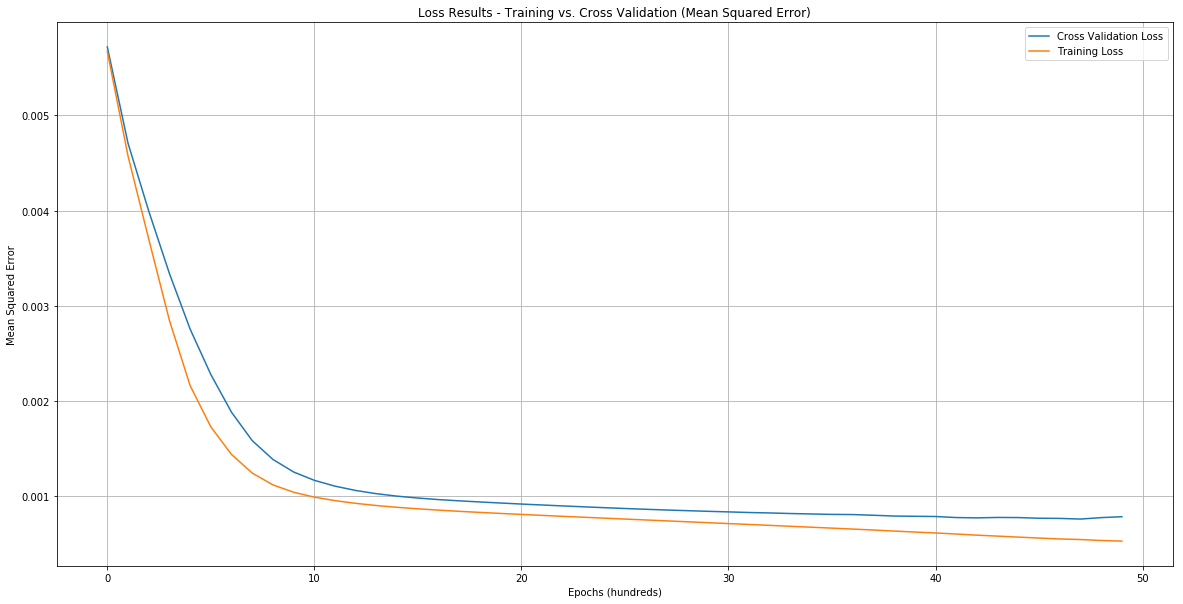

          Forecast : [396 381 441 446 468 518 608 613 516 442 408 445]
            Actual : [417 391 419 461 472 535 622 606 508 461 390 432]
Absolute Deviation : 167.12664794921875 Passengers
    Absolute Error : 2.94%


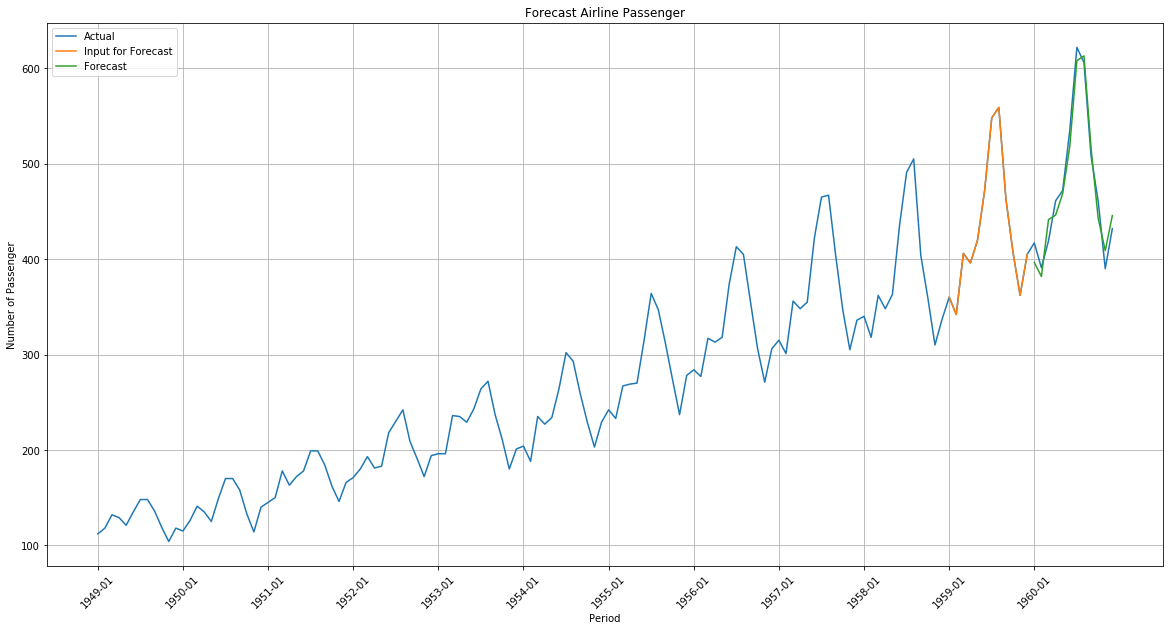

In [14]:
show_loss(history1)
show_results(df,scaler.inverse_transform(predictX),predictY1)

#### Activation Sigmoid

when I started working with Neural Networks, the Sigmoid Activation faction was predominant used. I will show at the end what the results are using Sigmoid. As we used a MinMaxScaler with a range of 0.1-0.9, there is no need to change the data source

In [15]:
model2=keras.Sequential()
model2.add(keras.layers.Dense(37,activation='sigmoid', input_dim=ts_input_size, use_bias=True))
model2.add(keras.layers.Dense(19,activation='sigmoid', use_bias=True))
model2.add(keras.layers.Dense(ts_target_size, activation='sigmoid', use_bias=True))

model2.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_squared_error']
)
history2=model2.fit(x_trainbatches, y_trainbatches, epochs=5000,
                               batch_size=len(x_trainbatches),
                               validation_data=(x_testbatches, y_testbatches),
                               validation_freq=100, 
                               use_multiprocessing=True)
predictY2=scaler.inverse_transform(model2.predict(predictX))

Epoch 1/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0561 - mean_squared_error: 0.0561
Epoch 2/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0551 - mean_squared_error: 0.0551
Epoch 3/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0540 - mean_squared_error: 0.0540
Epoch 4/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0530 - mean_squared_error: 0.0530
Epoch 5/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0520 - mean_squared_error: 0.0520
Epoch 6/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0511 - mean_squared_error: 0.0511
Epoch 7/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0502 - mean_squared_error: 0.0502
Epoch 8/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0492 - mean_squared_error: 0.0492
Epoch 9/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0484 - mean_squared_error: 0.0484
Epoch 10/5000
1/1 [================

1/1 [==============================] - 0s 16ms/step - loss: 0.0272 - mean_squared_error: 0.0272
Epoch 77/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0272 - mean_squared_error: 0.0272
Epoch 78/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0272 - mean_squared_error: 0.0272
Epoch 79/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0271 - mean_squared_error: 0.0271
Epoch 80/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0271 - mean_squared_error: 0.0271
Epoch 81/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0271 - mean_squared_error: 0.0271
Epoch 82/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0270 - mean_squared_error: 0.0270
Epoch 83/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0270 - mean_squared_error: 0.0270
Epoch 84/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0270 - mean_squared_error: 0.0270
Epoch 85/5000
1/1 [=====================

1/1 [==============================] - 0s 0s/step - loss: 0.0253 - mean_squared_error: 0.0253
Epoch 151/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0253 - mean_squared_error: 0.0253
Epoch 152/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0252 - mean_squared_error: 0.0252
Epoch 153/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0252 - mean_squared_error: 0.0252
Epoch 154/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0252 - mean_squared_error: 0.0252
Epoch 155/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0251 - mean_squared_error: 0.0251
Epoch 156/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0251 - mean_squared_error: 0.0251
Epoch 157/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0250 - mean_squared_error: 0.0250
Epoch 158/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0250 - mean_squared_error: 0.0250
Epoch 159/5000
1/1 [==============

1/1 [==============================] - 0s 0s/step - loss: 0.0209 - mean_squared_error: 0.0209
Epoch 225/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0208 - mean_squared_error: 0.0208
Epoch 226/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0207 - mean_squared_error: 0.0207
Epoch 227/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0206 - mean_squared_error: 0.0206
Epoch 228/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0205 - mean_squared_error: 0.0205
Epoch 229/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0204 - mean_squared_error: 0.0204
Epoch 230/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0204 - mean_squared_error: 0.0204
Epoch 231/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0203 - mean_squared_error: 0.0203
Epoch 232/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0202 - mean_squared_error: 0.0202
Epoch 233/5000
1/1 [==============

1/1 [==============================] - 0s 0s/step - loss: 0.0140 - mean_squared_error: 0.0140
Epoch 300/5000
1/1 [==============================] - 0s 17ms/step - loss: 0.0139 - mean_squared_error: 0.0139 - val_loss: 0.0137 - val_mean_squared_error: 0.0137
Epoch 301/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0138 - mean_squared_error: 0.0138
Epoch 302/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0138 - mean_squared_error: 0.0138
Epoch 303/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0137 - mean_squared_error: 0.0137
Epoch 304/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0136 - mean_squared_error: 0.0136
Epoch 305/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0135 - mean_squared_error: 0.0135
Epoch 306/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0134 - mean_squared_error: 0.0134
Epoch 307/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0134 - mean_sq

1/1 [==============================] - 0s 0s/step - loss: 0.0093 - mean_squared_error: 0.0093
Epoch 374/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0093 - mean_squared_error: 0.0093
Epoch 375/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0093 - mean_squared_error: 0.0093
Epoch 376/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0092 - mean_squared_error: 0.0092
Epoch 377/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0092 - mean_squared_error: 0.0092
Epoch 378/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0091 - mean_squared_error: 0.0091
Epoch 379/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0091 - mean_squared_error: 0.0091
Epoch 380/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0090 - mean_squared_error: 0.0090
Epoch 381/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0090 - mean_squared_error: 0.0090
Epoch 382/5000
1/1 [=============

1/1 [==============================] - 0s 0s/step - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 448/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 449/5000
1/1 [==============================] - 0s 7ms/step - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 450/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 451/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 452/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 453/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 454/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 455/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 456/5000
1/1 [=============

1/1 [==============================] - 0s 0s/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 522/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 523/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 524/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 525/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 526/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 527/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 528/5000
1/1 [==============================] - 0s 925us/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 529/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 530/5000
1/1 [===========

1/1 [==============================] - 0s 0s/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 597/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 598/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 599/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 600/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0055 - val_mean_squared_error: 0.0055
Epoch 601/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 602/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 603/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 604/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0057 - mean_sq

1/1 [==============================] - 0s 0s/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 671/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 672/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 673/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 674/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 675/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 676/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 677/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 678/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 679/5000
1/1 [==========

1/1 [==============================] - 0s 7ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 745/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 746/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 747/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 748/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 749/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 750/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 751/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 752/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 753/5000
1/1 [=========

1/1 [==============================] - 0s 0s/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 819/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 820/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 821/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 822/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 823/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 824/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 825/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 826/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 827/5000
1/1 [==============

1/1 [==============================] - 0s 0s/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 893/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 894/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 895/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 896/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 897/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 898/5000
1/1 [==============================] - 0s 998us/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 899/5000
1/1 [==============================] - 0s 998us/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 900/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0052 - val_me

1/1 [==============================] - 0s 0s/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 967/5000
1/1 [==============================] - 0s 7ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 968/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 969/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 970/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 971/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 972/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 973/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 974/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 975/5000
1/1 [===========

1/1 [==============================] - 0s 0s/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 1040/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 1041/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 1042/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 1043/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 1044/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 1045/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 1046/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 1047/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 1048/5000
1/1 [===

1/1 [==============================] - 0s 0s/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 1113/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 1114/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 1115/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 1116/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 1117/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 1118/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 1119/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 1120/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 1121/5000
1/1 [=====

1/1 [==============================] - 0s 0s/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 1187/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 1188/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 1189/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 1190/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 1191/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 1192/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 1193/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 1194/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 1195/5000
1/1 [===

1/1 [==============================] - 0s 0s/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 1261/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 1262/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 1263/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 1264/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 1265/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 1266/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 1267/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 1268/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 1269/5000
1/1 [=====

1/1 [==============================] - 0s 0s/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 1335/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 1336/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 1337/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 1338/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 1339/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 1340/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 1341/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 1342/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 1343/5000
1/1 [===

Epoch 1408/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 1409/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 1410/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 1411/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 1412/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 1413/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 1414/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 1415/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 1416/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 1417

1/1 [==============================] - 0s 0s/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 1483/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 1484/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 1485/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 1486/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 1487/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 1488/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 1489/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 1490/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 1491/5000
1/1 [=====

1/1 [==============================] - 0s 0s/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 1557/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 1558/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 1559/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 1560/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 1561/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 1562/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 1563/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 1564/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 1565/5000
1/1 [=====

Epoch 1630/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 1631/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1632/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1633/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1634/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1635/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1636/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1637/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1638/5000
1/1 [==============================] - 0s 1000us/step - loss: 0.0034 - mean_squared_error: 0.0034
Ep

1/1 [==============================] - 0s 0s/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 1704/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 1705/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 1706/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 1707/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 1708/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 1709/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 1710/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 1711/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 1712/5000
1/1 [=====

1/1 [==============================] - 0s 0s/step - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 1778/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 1779/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 1780/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 1781/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 1782/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 1783/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 1784/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 1785/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 1786/5000
1/1 [===

1/1 [==============================] - 0s 0s/step - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 1851/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 1852/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 1853/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 1854/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 1855/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 1856/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 1857/5000
1/1 [==============================] - 0s 760us/step - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 1858/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 1859/5000
1/1 [=

Epoch 1924/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 1925/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 1926/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 1927/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 1928/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 1929/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 1930/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 1931/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 1932/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 1933

1/1 [==============================] - 0s 0s/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 1999/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 2000/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 2001/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 2002/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 2003/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 2004/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 2005/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 2006/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0020 

1/1 [==============================] - 0s 997us/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 2072/5000
1/1 [==============================] - 0s 999us/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 2073/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 2074/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 2075/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 2076/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 2077/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 2078/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 2079/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 2080/5000
1/1

1/1 [==============================] - 0s 0s/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 2145/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 2146/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 2147/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 2148/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 2149/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 2150/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 2151/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 2152/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 2153/5000
1/1 [=====

1/1 [==============================] - 0s 0s/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 2219/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 2220/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 2221/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 2222/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 2223/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 2224/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 2225/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 2226/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 2227/5000
1/1 [=

1/1 [==============================] - 0s 0s/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 2293/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 2294/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 2295/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 2296/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 2297/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 2298/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 2299/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 2300/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0019 - val

1/1 [==============================] - 0s 0s/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 2367/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 2368/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 2369/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 2370/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 2371/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 2372/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 2373/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 2374/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 2375/5000
1/1 [===

1/1 [==============================] - 0s 0s/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 2440/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 2441/5000
1/1 [==============================] - ETA: 0s - loss: 0.0019 - mean_squared_error: 0.00 - 0s 0s/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 2442/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 2443/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 2444/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 2445/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 2446/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 2447/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0019 - m

1/1 [==============================] - 0s 0s/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 2513/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 2514/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 2515/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 2516/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 2517/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 2518/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 2519/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 2520/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 2521/5000
1/1 [=====

1/1 [==============================] - 0s 0s/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 2587/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 2588/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 2589/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 2590/5000
1/1 [==============================] - 0s 998us/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 2591/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 2592/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 2593/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 2594/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 2595/5000
1/1 [==

Epoch 2660/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 2661/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 2662/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 2663/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 2664/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 2665/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 2666/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 2667/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 2668/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 26

1/1 [==============================] - 0s 16ms/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 2734/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 2735/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 2736/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 2737/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 2738/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 2739/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 2740/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 2741/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 2742/5000
1/1 [===

1/1 [==============================] - 0s 0s/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 2807/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 2808/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 2809/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 2810/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 2811/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 2812/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 2813/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 2814/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 2815/5000
1/1 [=====

1/1 [==============================] - 0s 0s/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 2881/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 2882/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 2883/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 2884/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 2885/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 2886/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 2887/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 2888/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 2889/5000
1/1 [===

1/1 [==============================] - 0s 0s/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 2955/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 2956/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 2957/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 2958/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 2959/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 2960/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 2961/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 2962/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 2963/5000
1/1 [=====

Epoch 3028/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 3029/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 3030/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 3031/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 3032/5000
1/1 [==============================] - 0s 1ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 3033/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 3034/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 3035/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 3036/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 303

1/1 [==============================] - 0s 0s/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 3102/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 3103/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 3104/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 3105/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 3106/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 3107/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 3108/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 3109/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 3110/5000
1/1 [===

1/1 [==============================] - 0s 0s/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 3176/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 3177/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 3178/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 3179/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 3180/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 3181/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 3182/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 3183/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 3184/5000
1/1 [=====

Epoch 3249/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 3250/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 3251/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 3252/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 3253/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 3254/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 3255/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 3256/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 3257/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 32

1/1 [==============================] - 0s 0s/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 3323/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 3324/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 3325/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 3326/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 3327/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 3328/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 3329/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 3330/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 3331/5000
1/1 [===

1/1 [==============================] - 0s 0s/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 3397/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 3398/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 3399/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 3400/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 3401/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 3402/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 3403/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 3404/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0011 -

Epoch 3470/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 3471/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 3472/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 3473/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 3474/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 3475/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 3476/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 3477/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 3478/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 34

1/1 [==============================] - 0s 0s/step - loss: 9.8438e-04 - mean_squared_error: 9.8438e-04
Epoch 3542/5000
1/1 [==============================] - 0s 0s/step - loss: 9.8398e-04 - mean_squared_error: 9.8398e-04
Epoch 3543/5000
1/1 [==============================] - 0s 0s/step - loss: 9.8359e-04 - mean_squared_error: 9.8359e-04
Epoch 3544/5000
1/1 [==============================] - 0s 0s/step - loss: 9.8320e-04 - mean_squared_error: 9.8320e-04
Epoch 3545/5000
1/1 [==============================] - 0s 0s/step - loss: 9.8281e-04 - mean_squared_error: 9.8281e-04
Epoch 3546/5000
1/1 [==============================] - 0s 0s/step - loss: 9.8243e-04 - mean_squared_error: 9.8243e-04
Epoch 3547/5000
1/1 [==============================] - 0s 0s/step - loss: 9.8204e-04 - mean_squared_error: 9.8204e-04
Epoch 3548/5000
1/1 [==============================] - 0s 0s/step - loss: 9.8166e-04 - mean_squared_error: 9.8166e-04
Epoch 3549/5000
1/1 [==============================] - 0s 0s/step - loss

1/1 [==============================] - 0s 0s/step - loss: 9.6155e-04 - mean_squared_error: 9.6155e-04
Epoch 3610/5000
1/1 [==============================] - 0s 1ms/step - loss: 9.6126e-04 - mean_squared_error: 9.6126e-04
Epoch 3611/5000
1/1 [==============================] - 0s 0s/step - loss: 9.6098e-04 - mean_squared_error: 9.6098e-04
Epoch 3612/5000
1/1 [==============================] - ETA: 0s - loss: 9.6070e-04 - mean_squared_error: 9.6070e- - 0s 0s/step - loss: 9.6070e-04 - mean_squared_error: 9.6070e-04
Epoch 3613/5000
1/1 [==============================] - 0s 998us/step - loss: 9.6042e-04 - mean_squared_error: 9.6042e-04
Epoch 3614/5000
1/1 [==============================] - 0s 2ms/step - loss: 9.6015e-04 - mean_squared_error: 9.6015e-04
Epoch 3615/5000
1/1 [==============================] - 0s 0s/step - loss: 9.5987e-04 - mean_squared_error: 9.5987e-04
Epoch 3616/5000
1/1 [==============================] - 0s 0s/step - loss: 9.5959e-04 - mean_squared_error: 9.5959e-04
Epoch 3

1/1 [==============================] - 0s 0s/step - loss: 9.4499e-04 - mean_squared_error: 9.4499e-04
Epoch 3678/5000
1/1 [==============================] - 0s 0s/step - loss: 9.4478e-04 - mean_squared_error: 9.4478e-04
Epoch 3679/5000
1/1 [==============================] - 0s 0s/step - loss: 9.4457e-04 - mean_squared_error: 9.4457e-04
Epoch 3680/5000
1/1 [==============================] - 0s 0s/step - loss: 9.4437e-04 - mean_squared_error: 9.4437e-04
Epoch 3681/5000
1/1 [==============================] - 0s 0s/step - loss: 9.4416e-04 - mean_squared_error: 9.4416e-04
Epoch 3682/5000
1/1 [==============================] - 0s 0s/step - loss: 9.4396e-04 - mean_squared_error: 9.4396e-04
Epoch 3683/5000
1/1 [==============================] - 0s 0s/step - loss: 9.4375e-04 - mean_squared_error: 9.4375e-04
Epoch 3684/5000
1/1 [==============================] - 0s 0s/step - loss: 9.4355e-04 - mean_squared_error: 9.4355e-04
Epoch 3685/5000
1/1 [==============================] - 0s 16ms/step - lo

1/1 [==============================] - 0s 0s/step - loss: 9.3261e-04 - mean_squared_error: 9.3261e-04
Epoch 3746/5000
1/1 [==============================] - 0s 998us/step - loss: 9.3246e-04 - mean_squared_error: 9.3246e-04
Epoch 3747/5000
1/1 [==============================] - 0s 992us/step - loss: 9.3230e-04 - mean_squared_error: 9.3230e-04
Epoch 3748/5000
1/1 [==============================] - 0s 2ms/step - loss: 9.3214e-04 - mean_squared_error: 9.3214e-04
Epoch 3749/5000
1/1 [==============================] - 0s 0s/step - loss: 9.3198e-04 - mean_squared_error: 9.3198e-04
Epoch 3750/5000
1/1 [==============================] - 0s 0s/step - loss: 9.3183e-04 - mean_squared_error: 9.3183e-04
Epoch 3751/5000
1/1 [==============================] - 0s 0s/step - loss: 9.3167e-04 - mean_squared_error: 9.3167e-04
Epoch 3752/5000
1/1 [==============================] - 0s 0s/step - loss: 9.3152e-04 - mean_squared_error: 9.3152e-04
Epoch 3753/5000
1/1 [==============================] - 0s 0s/step

1/1 [==============================] - 0s 0s/step - loss: 9.2302e-04 - mean_squared_error: 9.2302e-04
Epoch 3814/5000
1/1 [==============================] - 0s 0s/step - loss: 9.2289e-04 - mean_squared_error: 9.2289e-04
Epoch 3815/5000
1/1 [==============================] - 0s 0s/step - loss: 9.2277e-04 - mean_squared_error: 9.2277e-04
Epoch 3816/5000
1/1 [==============================] - 0s 0s/step - loss: 9.2264e-04 - mean_squared_error: 9.2264e-04
Epoch 3817/5000
1/1 [==============================] - 0s 0s/step - loss: 9.2252e-04 - mean_squared_error: 9.2252e-04
Epoch 3818/5000
1/1 [==============================] - 0s 0s/step - loss: 9.2239e-04 - mean_squared_error: 9.2239e-04
Epoch 3819/5000
1/1 [==============================] - 0s 0s/step - loss: 9.2227e-04 - mean_squared_error: 9.2227e-04
Epoch 3820/5000
1/1 [==============================] - 0s 16ms/step - loss: 9.2215e-04 - mean_squared_error: 9.2215e-04
Epoch 3821/5000
1/1 [==============================] - 0s 0s/step - lo

1/1 [==============================] - 0s 0s/step - loss: 9.1517e-04 - mean_squared_error: 9.1517e-04
Epoch 3883/5000
1/1 [==============================] - 0s 0s/step - loss: 9.1506e-04 - mean_squared_error: 9.1506e-04
Epoch 3884/5000
1/1 [==============================] - 0s 0s/step - loss: 9.1496e-04 - mean_squared_error: 9.1496e-04
Epoch 3885/5000
1/1 [==============================] - 0s 0s/step - loss: 9.1486e-04 - mean_squared_error: 9.1486e-04
Epoch 3886/5000
1/1 [==============================] - 0s 16ms/step - loss: 9.1475e-04 - mean_squared_error: 9.1475e-04
Epoch 3887/5000
1/1 [==============================] - 0s 0s/step - loss: 9.1465e-04 - mean_squared_error: 9.1465e-04
Epoch 3888/5000
1/1 [==============================] - 0s 0s/step - loss: 9.1455e-04 - mean_squared_error: 9.1455e-04
Epoch 3889/5000
1/1 [==============================] - 0s 0s/step - loss: 9.1445e-04 - mean_squared_error: 9.1445e-04
Epoch 3890/5000
1/1 [==============================] - 0s 16ms/step - 

Epoch 3951/5000
1/1 [==============================] - 0s 0s/step - loss: 9.0857e-04 - mean_squared_error: 9.0857e-04
Epoch 3952/5000
1/1 [==============================] - 0s 0s/step - loss: 9.0848e-04 - mean_squared_error: 9.0848e-04
Epoch 3953/5000
1/1 [==============================] - 0s 0s/step - loss: 9.0839e-04 - mean_squared_error: 9.0839e-04
Epoch 3954/5000
1/1 [==============================] - 0s 0s/step - loss: 9.0830e-04 - mean_squared_error: 9.0830e-04
Epoch 3955/5000
1/1 [==============================] - 0s 16ms/step - loss: 9.0822e-04 - mean_squared_error: 9.0822e-04
Epoch 3956/5000
1/1 [==============================] - 0s 0s/step - loss: 9.0813e-04 - mean_squared_error: 9.0813e-04
Epoch 3957/5000
1/1 [==============================] - 0s 0s/step - loss: 9.0804e-04 - mean_squared_error: 9.0804e-04
Epoch 3958/5000
1/1 [==============================] - 0s 0s/step - loss: 9.0795e-04 - mean_squared_error: 9.0795e-04
Epoch 3959/5000
1/1 [==============================] -

1/1 [==============================] - 0s 0s/step - loss: 9.0288e-04 - mean_squared_error: 9.0288e-04
Epoch 4020/5000
1/1 [==============================] - 0s 0s/step - loss: 9.0280e-04 - mean_squared_error: 9.0280e-04
Epoch 4021/5000
1/1 [==============================] - 0s 0s/step - loss: 9.0272e-04 - mean_squared_error: 9.0272e-04
Epoch 4022/5000
1/1 [==============================] - 0s 0s/step - loss: 9.0264e-04 - mean_squared_error: 9.0264e-04
Epoch 4023/5000
1/1 [==============================] - 0s 0s/step - loss: 9.0256e-04 - mean_squared_error: 9.0256e-04
Epoch 4024/5000
1/1 [==============================] - 0s 0s/step - loss: 9.0248e-04 - mean_squared_error: 9.0248e-04
Epoch 4025/5000
1/1 [==============================] - 0s 0s/step - loss: 9.0240e-04 - mean_squared_error: 9.0240e-04
Epoch 4026/5000
1/1 [==============================] - 0s 16ms/step - loss: 9.0232e-04 - mean_squared_error: 9.0232e-04
Epoch 4027/5000
1/1 [==============================] - 0s 0s/step - lo

1/1 [==============================] - 0s 0s/step - loss: 8.9763e-04 - mean_squared_error: 8.9763e-04
Epoch 4089/5000
1/1 [==============================] - 0s 0s/step - loss: 8.9756e-04 - mean_squared_error: 8.9756e-04
Epoch 4090/5000
1/1 [==============================] - 0s 0s/step - loss: 8.9748e-04 - mean_squared_error: 8.9748e-04
Epoch 4091/5000
1/1 [==============================] - 0s 0s/step - loss: 8.9741e-04 - mean_squared_error: 8.9741e-04
Epoch 4092/5000
1/1 [==============================] - 0s 16ms/step - loss: 8.9734e-04 - mean_squared_error: 8.9734e-04
Epoch 4093/5000
1/1 [==============================] - 0s 0s/step - loss: 8.9727e-04 - mean_squared_error: 8.9727e-04
Epoch 4094/5000
1/1 [==============================] - 0s 0s/step - loss: 8.9719e-04 - mean_squared_error: 8.9719e-04
Epoch 4095/5000
1/1 [==============================] - 0s 0s/step - loss: 8.9712e-04 - mean_squared_error: 8.9712e-04
Epoch 4096/5000
1/1 [==============================] - 0s 0s/step - lo

1/1 [==============================] - 0s 16ms/step - loss: 8.9279e-04 - mean_squared_error: 8.9279e-04
Epoch 4157/5000
1/1 [==============================] - 0s 0s/step - loss: 8.9272e-04 - mean_squared_error: 8.9272e-04
Epoch 4158/5000
1/1 [==============================] - 0s 0s/step - loss: 8.9265e-04 - mean_squared_error: 8.9265e-04
Epoch 4159/5000
1/1 [==============================] - 0s 0s/step - loss: 8.9258e-04 - mean_squared_error: 8.9258e-04
Epoch 4160/5000
1/1 [==============================] - 0s 0s/step - loss: 8.9251e-04 - mean_squared_error: 8.9251e-04
Epoch 4161/5000
1/1 [==============================] - 0s 0s/step - loss: 8.9244e-04 - mean_squared_error: 8.9244e-04
Epoch 4162/5000
1/1 [==============================] - 0s 0s/step - loss: 8.9237e-04 - mean_squared_error: 8.9237e-04
Epoch 4163/5000
1/1 [==============================] - 0s 0s/step - loss: 8.9230e-04 - mean_squared_error: 8.9230e-04
Epoch 4164/5000
1/1 [==============================] - 0s 0s/step - lo

1/1 [==============================] - 0s 0s/step - loss: 8.8807e-04 - mean_squared_error: 8.8807e-04
Epoch 4226/5000
1/1 [==============================] - 0s 16ms/step - loss: 8.8800e-04 - mean_squared_error: 8.8800e-04
Epoch 4227/5000
1/1 [==============================] - 0s 0s/step - loss: 8.8793e-04 - mean_squared_error: 8.8793e-04
Epoch 4228/5000
1/1 [==============================] - 0s 0s/step - loss: 8.8787e-04 - mean_squared_error: 8.8787e-04
Epoch 4229/5000
1/1 [==============================] - 0s 0s/step - loss: 8.8780e-04 - mean_squared_error: 8.8780e-04
Epoch 4230/5000
1/1 [==============================] - 0s 0s/step - loss: 8.8773e-04 - mean_squared_error: 8.8773e-04
Epoch 4231/5000
1/1 [==============================] - 0s 0s/step - loss: 8.8767e-04 - mean_squared_error: 8.8767e-04
Epoch 4232/5000
1/1 [==============================] - 0s 0s/step - loss: 8.8760e-04 - mean_squared_error: 8.8760e-04
Epoch 4233/5000
1/1 [==============================] - 0s 0s/step - lo

1/1 [==============================] - 0s 0s/step - loss: 8.8345e-04 - mean_squared_error: 8.8345e-04
Epoch 4295/5000
1/1 [==============================] - 0s 0s/step - loss: 8.8338e-04 - mean_squared_error: 8.8338e-04
Epoch 4296/5000
1/1 [==============================] - 0s 0s/step - loss: 8.8331e-04 - mean_squared_error: 8.8331e-04
Epoch 4297/5000
1/1 [==============================] - 0s 16ms/step - loss: 8.8325e-04 - mean_squared_error: 8.8325e-04
Epoch 4298/5000
1/1 [==============================] - 0s 0s/step - loss: 8.8318e-04 - mean_squared_error: 8.8318e-04
Epoch 4299/5000
1/1 [==============================] - 0s 0s/step - loss: 8.8311e-04 - mean_squared_error: 8.8311e-04
Epoch 4300/5000
1/1 [==============================] - 0s 16ms/step - loss: 8.8305e-04 - mean_squared_error: 8.8305e-04 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 4301/5000
1/1 [==============================] - 0s 0s/step - loss: 8.8298e-04 - mean_squared_error: 8.8298e-04
Epoch 4302/5000


1/1 [==============================] - 0s 0s/step - loss: 8.7891e-04 - mean_squared_error: 8.7891e-04
Epoch 4363/5000
1/1 [==============================] - 0s 0s/step - loss: 8.7884e-04 - mean_squared_error: 8.7884e-04
Epoch 4364/5000
1/1 [==============================] - 0s 16ms/step - loss: 8.7878e-04 - mean_squared_error: 8.7878e-04
Epoch 4365/5000
1/1 [==============================] - 0s 0s/step - loss: 8.7871e-04 - mean_squared_error: 8.7871e-04
Epoch 4366/5000
1/1 [==============================] - 0s 0s/step - loss: 8.7864e-04 - mean_squared_error: 8.7864e-04
Epoch 4367/5000
1/1 [==============================] - 0s 0s/step - loss: 8.7857e-04 - mean_squared_error: 8.7857e-04
Epoch 4368/5000
1/1 [==============================] - 0s 0s/step - loss: 8.7851e-04 - mean_squared_error: 8.7851e-04
Epoch 4369/5000
1/1 [==============================] - 0s 0s/step - loss: 8.7844e-04 - mean_squared_error: 8.7844e-04
Epoch 4370/5000
1/1 [==============================] - 0s 0s/step - lo

1/1 [==============================] - 0s 0s/step - loss: 8.7433e-04 - mean_squared_error: 8.7433e-04
Epoch 4431/5000
1/1 [==============================] - 0s 0s/step - loss: 8.7426e-04 - mean_squared_error: 8.7426e-04
Epoch 4432/5000
1/1 [==============================] - 0s 16ms/step - loss: 8.7420e-04 - mean_squared_error: 8.7420e-04
Epoch 4433/5000
1/1 [==============================] - 0s 0s/step - loss: 8.7413e-04 - mean_squared_error: 8.7413e-04
Epoch 4434/5000
1/1 [==============================] - 0s 0s/step - loss: 8.7406e-04 - mean_squared_error: 8.7406e-04
Epoch 4435/5000
1/1 [==============================] - 0s 0s/step - loss: 8.7399e-04 - mean_squared_error: 8.7399e-04
Epoch 4436/5000
1/1 [==============================] - 0s 0s/step - loss: 8.7392e-04 - mean_squared_error: 8.7392e-04
Epoch 4437/5000
1/1 [==============================] - 0s 0s/step - loss: 8.7386e-04 - mean_squared_error: 8.7386e-04
Epoch 4438/5000
1/1 [==============================] - 0s 0s/step - lo

1/1 [==============================] - 0s 998us/step - loss: 8.6960e-04 - mean_squared_error: 8.6960e-04
Epoch 4500/5000
1/1 [==============================] - 0s 16ms/step - loss: 8.6953e-04 - mean_squared_error: 8.6953e-04 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 4501/5000
1/1 [==============================] - 0s 2ms/step - loss: 8.6946e-04 - mean_squared_error: 8.6946e-04
Epoch 4502/5000
1/1 [==============================] - 0s 998us/step - loss: 8.6939e-04 - mean_squared_error: 8.6939e-04
Epoch 4503/5000
1/1 [==============================] - 0s 996us/step - loss: 8.6932e-04 - mean_squared_error: 8.6932e-04
Epoch 4504/5000
1/1 [==============================] - 0s 0s/step - loss: 8.6925e-04 - mean_squared_error: 8.6925e-04
Epoch 4505/5000
1/1 [==============================] - 0s 0s/step - loss: 8.6918e-04 - mean_squared_error: 8.6918e-04
Epoch 4506/5000
1/1 [==============================] - 0s 0s/step - loss: 8.6911e-04 - mean_squared_error: 8.6911e-04
Epoch 45

1/1 [==============================] - 0s 0s/step - loss: 8.6479e-04 - mean_squared_error: 8.6479e-04
Epoch 4568/5000
1/1 [==============================] - 0s 0s/step - loss: 8.6472e-04 - mean_squared_error: 8.6472e-04
Epoch 4569/5000
1/1 [==============================] - 0s 0s/step - loss: 8.6465e-04 - mean_squared_error: 8.6465e-04
Epoch 4570/5000
1/1 [==============================] - 0s 16ms/step - loss: 8.6458e-04 - mean_squared_error: 8.6458e-04
Epoch 4571/5000
1/1 [==============================] - 0s 0s/step - loss: 8.6451e-04 - mean_squared_error: 8.6451e-04
Epoch 4572/5000
1/1 [==============================] - 0s 0s/step - loss: 8.6443e-04 - mean_squared_error: 8.6443e-04
Epoch 4573/5000
1/1 [==============================] - 0s 0s/step - loss: 8.6436e-04 - mean_squared_error: 8.6436e-04
Epoch 4574/5000
1/1 [==============================] - 0s 0s/step - loss: 8.6429e-04 - mean_squared_error: 8.6429e-04
Epoch 4575/5000
1/1 [==============================] - 0s 0s/step - lo

1/1 [==============================] - 0s 0s/step - loss: 8.5981e-04 - mean_squared_error: 8.5981e-04
Epoch 4636/5000
1/1 [==============================] - 0s 0s/step - loss: 8.5974e-04 - mean_squared_error: 8.5974e-04
Epoch 4637/5000
1/1 [==============================] - 0s 0s/step - loss: 8.5967e-04 - mean_squared_error: 8.5967e-04
Epoch 4638/5000
1/1 [==============================] - 0s 0s/step - loss: 8.5959e-04 - mean_squared_error: 8.5959e-04
Epoch 4639/5000
1/1 [==============================] - 0s 0s/step - loss: 8.5952e-04 - mean_squared_error: 8.5952e-04
Epoch 4640/5000
1/1 [==============================] - 0s 0s/step - loss: 8.5944e-04 - mean_squared_error: 8.5944e-04
Epoch 4641/5000
1/1 [==============================] - 0s 0s/step - loss: 8.5937e-04 - mean_squared_error: 8.5937e-04
Epoch 4642/5000
1/1 [==============================] - 0s 0s/step - loss: 8.5929e-04 - mean_squared_error: 8.5929e-04
Epoch 4643/5000
1/1 [==============================] - 0s 0s/step - loss

1/1 [==============================] - 0s 0s/step - loss: 8.5454e-04 - mean_squared_error: 8.5454e-04
Epoch 4705/5000
1/1 [==============================] - 0s 0s/step - loss: 8.5446e-04 - mean_squared_error: 8.5446e-04
Epoch 4706/5000
1/1 [==============================] - 0s 0s/step - loss: 8.5439e-04 - mean_squared_error: 8.5439e-04
Epoch 4707/5000
1/1 [==============================] - 0s 0s/step - loss: 8.5431e-04 - mean_squared_error: 8.5431e-04
Epoch 4708/5000
1/1 [==============================] - 0s 0s/step - loss: 8.5423e-04 - mean_squared_error: 8.5423e-04
Epoch 4709/5000
1/1 [==============================] - 0s 0s/step - loss: 8.5415e-04 - mean_squared_error: 8.5415e-04
Epoch 4710/5000
1/1 [==============================] - 0s 0s/step - loss: 8.5407e-04 - mean_squared_error: 8.5407e-04
Epoch 4711/5000
1/1 [==============================] - 0s 0s/step - loss: 8.5399e-04 - mean_squared_error: 8.5399e-04
Epoch 4712/5000
1/1 [==============================] - 0s 0s/step - loss

1/1 [==============================] - 0s 7ms/step - loss: 8.4901e-04 - mean_squared_error: 8.4901e-04
Epoch 4774/5000
1/1 [==============================] - 0s 0s/step - loss: 8.4892e-04 - mean_squared_error: 8.4892e-04
Epoch 4775/5000
1/1 [==============================] - 0s 0s/step - loss: 8.4884e-04 - mean_squared_error: 8.4884e-04
Epoch 4776/5000
1/1 [==============================] - 0s 0s/step - loss: 8.4876e-04 - mean_squared_error: 8.4876e-04
Epoch 4777/5000
1/1 [==============================] - 0s 16ms/step - loss: 8.4868e-04 - mean_squared_error: 8.4868e-04
Epoch 4778/5000
1/1 [==============================] - 0s 0s/step - loss: 8.4859e-04 - mean_squared_error: 8.4859e-04
Epoch 4779/5000
1/1 [==============================] - 0s 0s/step - loss: 8.4851e-04 - mean_squared_error: 8.4851e-04
Epoch 4780/5000
1/1 [==============================] - 0s 0s/step - loss: 8.4843e-04 - mean_squared_error: 8.4843e-04
Epoch 4781/5000
1/1 [==============================] - 0s 0s/step - l

Epoch 4842/5000
1/1 [==============================] - 0s 0s/step - loss: 8.4317e-04 - mean_squared_error: 8.4317e-04
Epoch 4843/5000
1/1 [==============================] - 0s 1ms/step - loss: 8.4308e-04 - mean_squared_error: 8.4308e-04
Epoch 4844/5000
1/1 [==============================] - 0s 1ms/step - loss: 8.4299e-04 - mean_squared_error: 8.4299e-04
Epoch 4845/5000
1/1 [==============================] - 0s 2ms/step - loss: 8.4291e-04 - mean_squared_error: 8.4291e-04
Epoch 4846/5000
1/1 [==============================] - 0s 0s/step - loss: 8.4282e-04 - mean_squared_error: 8.4282e-04
Epoch 4847/5000
1/1 [==============================] - 0s 0s/step - loss: 8.4273e-04 - mean_squared_error: 8.4273e-04
Epoch 4848/5000
1/1 [==============================] - 0s 0s/step - loss: 8.4264e-04 - mean_squared_error: 8.4264e-04
Epoch 4849/5000
1/1 [==============================] - 0s 0s/step - loss: 8.4256e-04 - mean_squared_error: 8.4256e-04
Epoch 4850/5000
1/1 [==============================] 

1/1 [==============================] - 0s 0s/step - loss: 8.3708e-04 - mean_squared_error: 8.3708e-04
Epoch 4911/5000
1/1 [==============================] - 0s 0s/step - loss: 8.3698e-04 - mean_squared_error: 8.3698e-04
Epoch 4912/5000
1/1 [==============================] - 0s 0s/step - loss: 8.3689e-04 - mean_squared_error: 8.3689e-04
Epoch 4913/5000
1/1 [==============================] - 0s 0s/step - loss: 8.3680e-04 - mean_squared_error: 8.3680e-04
Epoch 4914/5000
1/1 [==============================] - 0s 0s/step - loss: 8.3671e-04 - mean_squared_error: 8.3671e-04
Epoch 4915/5000
1/1 [==============================] - 0s 0s/step - loss: 8.3661e-04 - mean_squared_error: 8.3661e-04
Epoch 4916/5000
1/1 [==============================] - 0s 0s/step - loss: 8.3652e-04 - mean_squared_error: 8.3652e-04
Epoch 4917/5000
1/1 [==============================] - 0s 0s/step - loss: 8.3643e-04 - mean_squared_error: 8.3643e-04
Epoch 4918/5000
1/1 [==============================] - 0s 0s/step - loss

1/1 [==============================] - 0s 0s/step - loss: 8.3052e-04 - mean_squared_error: 8.3052e-04
Epoch 4980/5000
1/1 [==============================] - 0s 0s/step - loss: 8.3042e-04 - mean_squared_error: 8.3042e-04
Epoch 4981/5000
1/1 [==============================] - 0s 0s/step - loss: 8.3032e-04 - mean_squared_error: 8.3032e-04
Epoch 4982/5000
1/1 [==============================] - 0s 0s/step - loss: 8.3022e-04 - mean_squared_error: 8.3022e-04
Epoch 4983/5000
1/1 [==============================] - 0s 0s/step - loss: 8.3012e-04 - mean_squared_error: 8.3012e-04
Epoch 4984/5000
1/1 [==============================] - 0s 0s/step - loss: 8.3002e-04 - mean_squared_error: 8.3002e-04
Epoch 4985/5000
1/1 [==============================] - 0s 0s/step - loss: 8.2993e-04 - mean_squared_error: 8.2993e-04
Epoch 4986/5000
1/1 [==============================] - 0s 0s/step - loss: 8.2983e-04 - mean_squared_error: 8.2983e-04
Epoch 4987/5000
1/1 [==============================] - 0s 0s/step - loss

Last Results loss:0.0008284375653602183, cross validation loss:0.001023044460453093


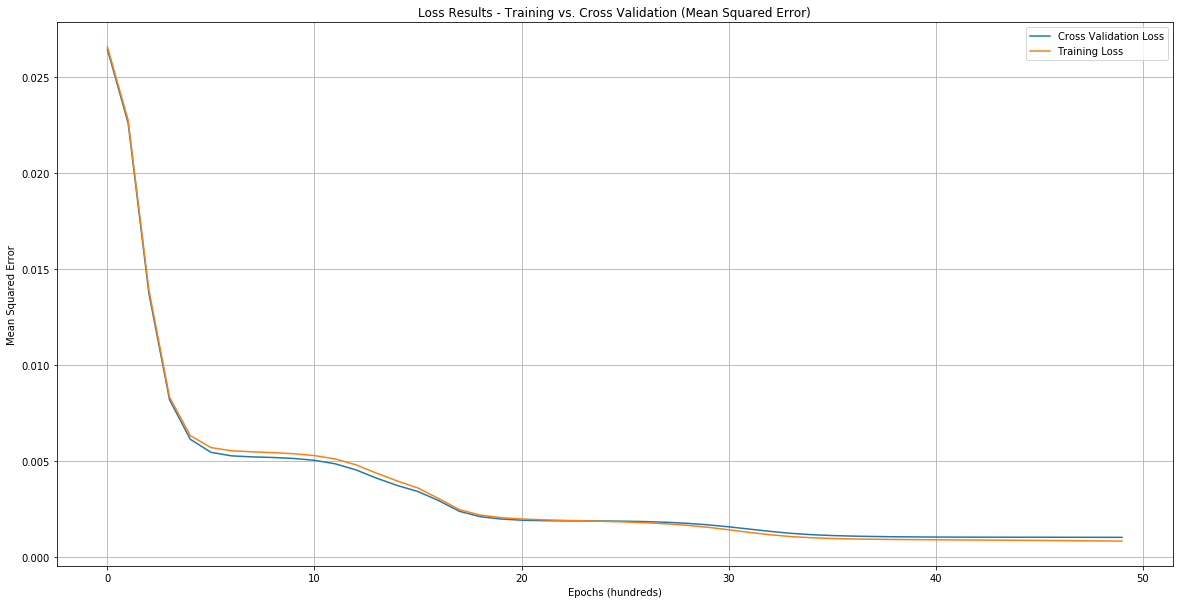

          Forecast : [386 399 389 405 443 491 526 525 495 426 390 397]
            Actual : [417 391 419 461 472 535 622 606 508 461 390 432]
Absolute Deviation : 454.79925537109375 Passengers
    Absolute Error : 8.62%


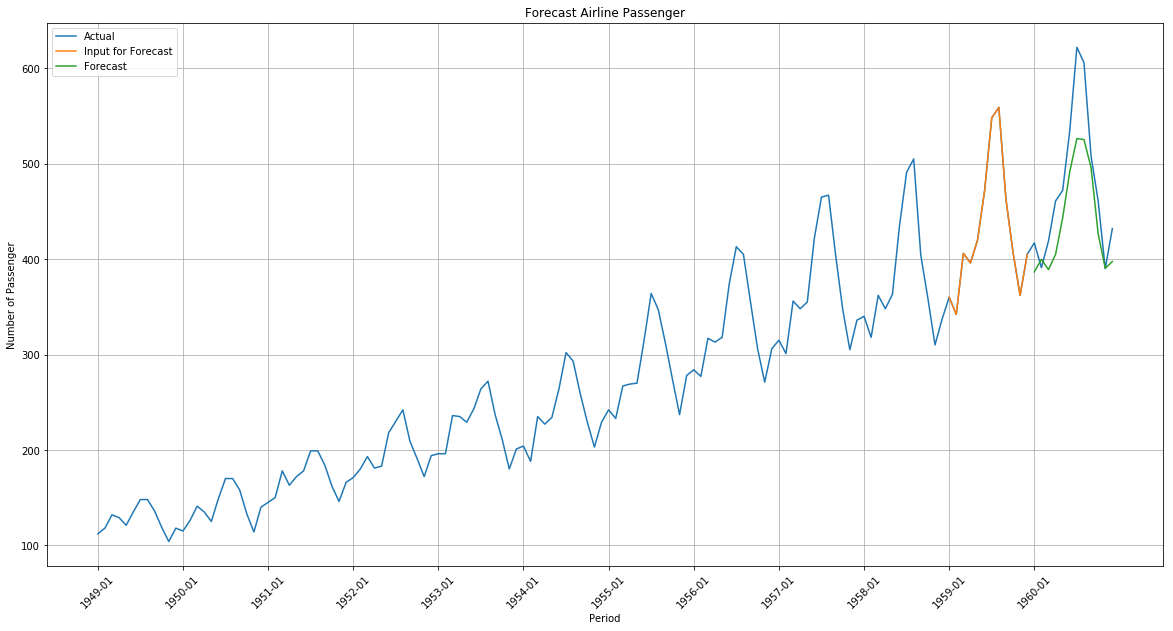

In [16]:
show_loss(history2)
show_results(df,scaler.inverse_transform(predictX),predictY2)

As I remarked before, the values on the edges will be flatten. Working with time series the ReLu or Leaky Relu Activation function work better on my experiences.